### CASA0002

# Urban Simulation
***
## Working with real world data

Mateo Neira
***

Working with real world data comes with its own set of challenges. In this practical we will go over downloading and processing the public TFL multi-rail demand data set for London, which can be found [here](http://crowding.data.tfl.gov.uk).

We will be using the data from the [NUMBAT project](http://crowding.data.tfl.gov.uk/NUMBAT/Intro_to_NUMBAT.pdf) -A comprehensive multi-rail demand data set for London. the NUMBAT dataset provides statistics on usage and travel patterns on TfL railway services. It is the most comprehensive multi-rail demand data set available for London.

### TFL Origin Destination data
***

We will be using the 2019 data set (as the 2020 dataset coincides with lockdown measures). The data TFL provides represents the travel demand on a typical autumn weekday (Monday-Thursday), Friday, Saturday, and Sunday at all stations and lines of the London Underground, London Overground, Docklands Light Railway, TfL Rail / Elizabeth Line (crossrail) and London Trams.

---
### Map of the network we will be constructing

![img](https://tfl.gov.uk/cdn/static/cms/images/london-rail-and-tube-services-map.gif)

### Data Processing

We need to perform the folling steps to get the data we need in the right format for to run the analysis required for the final assesment:


1. Download raw data
    * Get flow data from TFL 
    * Get geometries of the london rail & tube network from OSM
2. Preprocess the data
    * Data wrangling of flow data from TFL
    * Transform geometry of london rail & tube network into a graph
3. Merge TFL data and london underground shapefile
    * Calculate flow data to input as weights in london network graph
    * Calculate distances between stations to create file to be used in the spatial interaction model

---
_The raw data has already been provided for you in data /data folder. You can still explore the data directly from the links provided. In the case of the London rail & tube network geometries, these have been extracted from OSM._ 

### Data Wrangling of passenger flows

We will be focusing only on the data that covers Monday-Thursday. 

The first file we need is the [NBT19_Definitions.xlsx](http://crowding.data.tfl.gov.uk/NUMBAT/NUMBAT%202019/NBT19_Definitions.xlsx) file that contains important information on what  different codes mean. 

The rest of the files relate to the OD matrix for the different lines organized by timebands which can be found here: 

* [NBT19MTT2b_od_DLR_tb_wf.csv](http://crowding.data.tfl.gov.uk/NUMBAT/NUMBAT%202019/NBT19_OD_data/NBT19MTT2b_od__DLR_tb_wf.csv)
* [NBT19MTT2b_od__EZL_tb_wf.csv](http://crowding.data.tfl.gov.uk/NUMBAT/NUMBAT%202019/NBT19_OD_data/NBT19MTT2b_od__EZL_tb_wf.csv)
* [NBT19MTT2b_od__LO_tb_wf.csv](http://crowding.data.tfl.gov.uk/NUMBAT/NUMBAT%202019/NBT19_OD_data/NBT19MTT2b_od__LO_tb_wf.csv)
* [NBT19MTT2b_od__LU_tb_wf.csv](http://crowding.data.tfl.gov.uk/NUMBAT/NUMBAT%202019/NBT19_OD_data/NBT19MTT2b_od__LU_tb_wf.csv)

_*note that the MTT code in the file name refers to Monday to Thursday data as specified in the definitions file_

In [1419]:
# we will import all the necessary libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance

In [1420]:
#tlf provides passenger flow data for each network separately
#we need to create a list of all the different files we need
files = ['NBT19MTT2b_od__DLR_tb_wf.csv', 
         'NBT19MTT2b_od__EZL_tb_wf.csv', 
         'NBT19MTT2b_od__LO_tb_wf.csv', 
         'NBT19MTT2b_od__LU_tb_wf.csv']

#create an empty list to store dataframes for each file
dfs = []

#iterate through our files list, read the file and append to our dataframe list
for file in files:
    dfs.append(pd.read_csv('data/' + file))
    
#merge all dataframes
london_OD = pd.concat(dfs, ignore_index=True)

In [1421]:
#take a look at our data
london_OD.head()

,mode_mnlc_o,mode_mnlc_d,2,3,4,5,6,7,mode,1,8
0,504,523,8.033,16.430,24.563,28.555,13.023,2.263,DLR,NaN,NaN
1,504,533,30.719,40.105,61.571,57.881,15.573,0.317,DLR,NaN,NaN
2,504,538,5.941,17.238,37.493,43.158,33.890,10.429,DLR,NaN,NaN
3,504,559,5.795,26.397,27.285,24.065,15.213,8.508,DLR,NaN,NaN
4,504,573,77.786,113.750,143.938,387.562,165.776,65.283,DLR,NaN,NaN


#### Understanding our data

If we read the information on the **Numbat Project** which as linked previously we can see that the data covers 15-minute periods. The specific datasets we are using are the O/D by network which registers number of trips between Origin and Destination station by time band.

---
* mode_mnlc_o: code of origin station
* mode_mnlc_d: code of destionation station
* \[1,2,...,7,8\]: number of passengers in respective timeband
* mode: type of network (London Undeground, London Overgroud, DRL, ...)


Since we are only interested in home-to-work trips, we will only keep the data pertaining to the morning peak (7am - 10am). Again, if we look at the definition file we can see that this is timeband 3.

Additionally, we need to map the station codes to station names, we will be using the definition file for this.

### Get the mnlc codes 

We will use the **NBT19_Definitions.xlsx** file to get the codes to match station names.

```python
pd.read_excel()
```

The function requires the **openpyxl** library to work. this can be installed using pip or conda. 

In [1422]:
definition_df = pd.read_excel('data/NBT19_Definitions.xlsx', 'Stations')
definition_df.head()

,MNLC,MASC,StationName,TFL?
0,500.0,ACTu,Acton Town,True
1,501.0,BARu,Barbican,True
2,502.0,ALDu,Aldgate,True
3,503.0,ALEu,Aldgate East,True
4,504.0,STId,Stratford International DLR,True


In [1423]:
#we will drop any missing values from our dataframe
definition_df.dropna(inplace=True)

#transform mnlc codes from floats to int
definition_df.MNLC = definition_df.MNLC.astype(int)
definition_df.head()

,MNLC,MASC,StationName,TFL?
0,500,ACTu,Acton Town,True
1,501,BARu,Barbican,True
2,502,ALDu,Aldgate,True
3,503,ALEu,Aldgate East,True
4,504,STId,Stratford International DLR,True


In [1424]:
#add the station names
london_OD['station_origin'] = london_OD['mode_mnlc_o'].apply(lambda x: definition_df[definition_df.MNLC==x]['StationName'].values[0])
london_OD['station_destination'] = london_OD['mode_mnlc_d'].apply(lambda x: definition_df[definition_df.MNLC==x]['StationName'].values[0])
london_OD.head()

,mode_mnlc_o,mode_mnlc_d,2,3,4,5,6,7,mode,1,8,station_origin,station_destination
0,504,523,8.033,16.430,24.563,28.555,13.023,2.263,DLR,NaN,NaN,Stratford International DLR,King George V
1,504,533,30.719,40.105,61.571,57.881,15.573,0.317,DLR,NaN,NaN,Stratford International DLR,London City Airport
2,504,538,5.941,17.238,37.493,43.158,33.890,10.429,DLR,NaN,NaN,Stratford International DLR,Pontoon Dock
3,504,559,5.795,26.397,27.285,24.065,15.213,8.508,DLR,NaN,NaN,Stratford International DLR,West Silvertown
4,504,573,77.786,113.750,143.938,387.562,165.776,65.283,DLR,NaN,NaN,Stratford International DLR,Woolwich Arsenal


In [1425]:
# we will only keep passenger flows for the timeband we are interested in
london_OD_AMpeak = london_OD[['station_origin', 'station_destination', '3']].copy()
london_OD_AMpeak.head()

,station_origin,station_destination,3
0,Stratford International DLR,King George V,16.430
1,Stratford International DLR,London City Airport,40.105
2,Stratford International DLR,Pontoon Dock,17.238
3,Stratford International DLR,West Silvertown,26.397
4,Stratford International DLR,Woolwich Arsenal,113.750


In [1426]:
#rename column
london_OD_AMpeak.rename({'3':'flows'}, axis=1, inplace=True)

#since the flows are averages the are stored as flows.
#for our analysis we will turn the into ints
london_OD_AMpeak.flows = london_OD_AMpeak.flows.astype(int)
london_OD_AMpeak.head()

,station_origin,station_destination,flows
0,Stratford International DLR,King George V,16
1,Stratford International DLR,London City Airport,40
2,Stratford International DLR,Pontoon Dock,17
3,Stratford International DLR,West Silvertown,26
4,Stratford International DLR,Woolwich Arsenal,113


Let's get all the station names

In [1427]:
station_origin = list(london_OD_AMpeak.station_origin.values)
station_destination = list(london_OD_AMpeak.station_destination.values)
all_stations = list(set(station_origin + station_destination))
all_stations = sorted(all_stations, key=str.lower)

In [1428]:
all_stations

['Abbey Road',
 'Acton Central',
 'Acton Main Line',
 'Acton Town',
 'Aldgate',
 'Aldgate East',
 'All Saints',
 'Alperton',
 'Amersham',
 'Anerley',
 'Angel',
 'Archway',
 'Arnos Grove',
 'Arsenal',
 'Baker Street',
 'Balham LU',
 'Bank and Monument',
 'Barbican',
 'Barking',
 'Barkingside',
 'Barons Court',
 'Battersea Park',
 'Bayswater',
 'Beckton',
 'Beckton Park',
 'Becontree',
 'Belsize Park',
 'Bermondsey',
 'Bethnal Green LO',
 'Bethnal Green LU',
 'Blackfriars LU',
 'Blackhorse Road',
 'Blackwall',
 'Bond Street',
 'Borough',
 'Boston Manor',
 'Bounds Green',
 'Bow Church',
 'Bow Road',
 'Brent Cross',
 'Brentwood',
 'Brixton LU',
 'Brockley',
 'Bromley-by-Bow',
 'Brondesbury',
 'Brondesbury Park',
 'Bruce Grove',
 'Buckhurst Hill',
 'Burnt Oak',
 'Bush Hill Park',
 'Bushey',
 'Caledonian Road',
 'Caledonian Road & Barnsbury',
 'Cambridge Heath',
 'Camden Road',
 'Camden Town',
 'Canada Water',
 'Canary Wharf DLR',
 'Canary Wharf LU',
 'Canning Town',
 'Cannon Street LU',
 'C

We will need to clean this, as we want all stations that are the same summed. for example Hammersmith (DIS) and Hammersmith (H&C) are the same station. so we want these flows to be summed into one one just called Hammersmith. For this we will simplify all names by:
* removing all text in between ()
* removing LU, LO, NR, Tfl,  DLR

We will use [RegEx](https://en.wikipedia.org/wiki/Regular_expression) to match and replace station names. 

In [1429]:
london_OD_AMpeak['station_origin']= london_OD_AMpeak.station_origin.apply(lambda x: 
                                      re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', x)
                                     )
london_OD_AMpeak['station_destination']=london_OD_AMpeak.station_destination.apply(lambda x: 
                                      re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', x)
                                     )

now we will sum the flows of stations with the same origin-destination name

In [1430]:
#group by origin and destination station and sum the flows
london_OD_AMpeak = london_OD_AMpeak.groupby(['station_origin', 'station_destination'], as_index=False).sum()

In [1431]:
london_OD_AMpeak.head()

,station_origin,station_destination,flows
0,Abbey Road,Bank and Monument,0
1,Abbey Road,Beckton,1
2,Abbey Road,Blackwall,3
3,Abbey Road,Canary Wharf,1
4,Abbey Road,Canning Town,37


#### Does our data make sense?

* Do the stations with least and most in and out flows make sense?
* What type of data distribtion would we expect?

In [1432]:
#let's sanity check and see the highest and lowest flows in and out flows
outflows = london_OD_AMpeak.groupby('station_origin', as_index=False).sum()

In [1433]:
outflows.sort_values('flows').head(10)

,station_origin,station_destination,flows
21,Battersea Park,BrockleyCanada WaterClapham High StreetDalston...,0
385,West India Quay,All SaintsBank and MonumentBecktonBlackwallBow...,162
68,Cheshunt,BarkingBethnal GreenBruce GroveCambridge Heath...,171
49,Bushey,Acton CentralBarkingBrondesburyCarpenders Park...,238
167,Heathrow Terminals 2 & 3 EL,Ealing BroadwayHanwellHayes & HarlingtonHeathr...,242
307,South Hampstead,Acton CentralBusheyCarpenders ParkEustonGunner...,248
298,Shenfield,BrentwoodChadwell HeathForest GateGidea ParkGo...,248
186,Hyde Park Corner,Acton TownAldgateAldgate EastAlpertonAmershamA...,259
24,Beckton Park,Bank and MonumentBecktonBlackwallBow ChurchCan...,293
52,Cambridge Heath,Bethnal GreenBruce GroveBush Hill ParkCaledoni...,328


In [1434]:
outflows.sort_values('flows').tail(10)

,station_origin,station_destination,flows
258,Paddington,Acton Main LineActon TownAldgateAldgate EastAl...,24071
125,Finsbury Park,Acton TownAldgateAldgate EastAlpertonAmershamA...,24735
55,Canada Water,Acton CentralActon TownAlpertonAmershamAnerley...,27026
203,King's Cross St. Pancras,Acton TownAldgateAldgate EastAlpertonAmershamA...,28307
16,Bank and Monument,Abbey RoadActon TownAldgateAldgate EastAll Sai...,29494
218,Liverpool Street,Acton TownAldgateAldgate EastAlpertonAmershamA...,31473
219,London Bridge,Acton TownAldgateAldgate EastAlpertonAmershamA...,32597
362,Victoria,Acton TownAldgateAldgate EastAlpertonAmershamA...,37517
333,Stratford,Abbey RoadActon CentralActon TownAldgateAldgat...,59311
371,Waterloo,Acton TownAldgateAldgate EastAlpertonAmershamA...,67372


In [1435]:
#let's sanity check and see the highest and lowest flows in and out flows
inflows = london_OD_AMpeak.groupby('station_destination', as_index=False).sum()

In [1436]:
inflows.sort_values('flows').head(10)

,station_destination,station_origin,flows
21,Battersea Park,BrockleyCanada WaterClapham High StreetDalston...,0
115,Emerson Park,RomfordUpminster,42
2,Acton Main Line,Ealing BroadwayHayes & HarlingtonPaddingtonSou...,70
153,Hanwell,Ealing BroadwayHayes & HarlingtonHeathrow Term...,72
138,Grange Hill,Aldgate EastAngelBaker StreetBalhamBank and Mo...,76
285,Roding Valley,Aldgate EastAngelBank and MonumentBarbicanBark...,84
24,Beckton Park,Bank and MonumentBecktonBlackwallBow ChurchCan...,88
381,West Finchley,AldgateAldgate EastAngelArchwayBaker StreetBal...,91
159,Hatch End,Acton CentralBusheyCamden RoadCarpenders ParkC...,93
343,Theydon Bois,Aldgate EastAngelBank and MonumentBarbicanBark...,98


In [1437]:
inflows.sort_values('flows').tail(10)

,station_destination,station_origin,flows
121,Farringdon,Acton TownAldgateAldgate EastAlpertonAmershamA...,25592
140,Green Park,Acton TownAldgateAldgate EastAlpertonAmershamA...,26754
219,London Bridge,Acton TownAldgateAldgate EastAlpertonAmershamA...,29930
362,Victoria,Acton TownAldgateAldgate EastAlpertonAmershamA...,33251
203,King's Cross St. Pancras,Acton TownAldgateAldgate EastAlpertonAmershamA...,33330
257,Oxford Circus,Acton TownAldgateAldgate EastAlpertonAmershamA...,44368
333,Stratford,Abbey RoadActon CentralActon TownAldgateAldgat...,55954
56,Canary Wharf,Abbey RoadActon TownAldgateAldgate EastAll Sai...,58772
218,Liverpool Street,Acton TownAldgateAldgate EastAlpertonAmershamA...,61122
16,Bank and Monument,Abbey RoadActon TownAldgateAldgate EastAll Sai...,78549


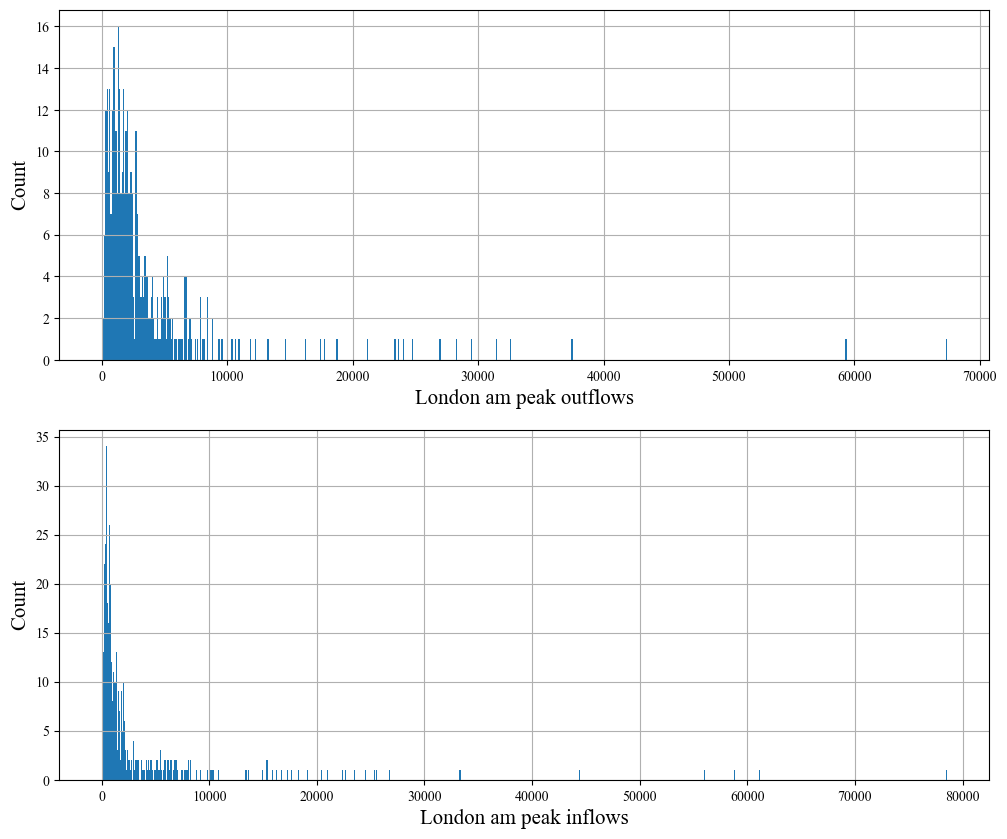

In [1438]:
#let's plot this as a histogram
bin_size=100
fig, ax = plt.subplots(2,1,figsize=(12,10))
ax[0].hist(outflows['flows'], bins=int(outflows['flows'].max()/bin_size))
ax[0].set_xlabel('London am peak outflows', fontsize = 15)
ax[0].set_ylabel("Count", fontsize= 15)
ax[0].grid(True)

ax[1].hist(inflows['flows'], bins=int(inflows['flows'].max()/bin_size))
ax[1].set_xlabel('London am peak inflows', fontsize = 15)
ax[1].set_ylabel("Count", fontsize= 15)
ax[1].grid(True)
plt.show()

### Load London Underground shapefile data

Now that we have our Origin-Destination data, we need to construct a network representing the london rail & tube services. This is a bit more tricky, because we need both a topologically correct network, plus clean geometries so we can calculate distances to use as weights. 

The raw data we are using comes from OSM and it's inherently messy. We have two seperate files, one for stations and another for the lines.

**These are the types of errors we will encounter:**

![errors](img/errors.png)


In [1439]:
#read in the data using geopandas
stations = gpd.read_file('data/tfl_stations.json')
lines = gpd.read_file('data/tfl_lines.json')

In [1440]:
#project data to British National Grid
#we do this so we can work in meters
stations = stations.to_crs(epsg = 27700)
lines = lines.to_crs(epsg = 27700)

### Stations file

In [1441]:
stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           529 non-null    object  
 1   name         529 non-null    object  
 2   nlc_id       518 non-null    object  
 3   lines        529 non-null    object  
 4   cartography  529 non-null    object  
 5   altmodeid    16 non-null     object  
 6   alt_id       337 non-null    object  
 7   altmodeid2   2 non-null      object  
 8   zone         529 non-null    object  
 9   geometry     529 non-null    geometry
dtypes: geometry(1), object(9)
memory usage: 41.5+ KB


In [1442]:
stations.head()

,id,name,nlc_id,lines,cartography,altmodeid,alt_id,altmodeid2,zone,geometry
0,940GZZLUACT,Acton Town,0500,"[ { ""name"": ""District"" }, { ""name"": ""Piccadill...",{'labelX': 30},None,1,None,3,POINT (519484.905 179592.101)
1,940GZZLUACY,Archway,0508,"[ { ""name"": ""Northern"", ""nightopened"": 2016 } ]",{'labelX': -30},None,8,None,2/3,POINT (529382.416 186814.396)
2,940GZZLUADE,Aldgate East,0503,"[ { ""name"": ""District"" }, { ""name"": ""Hammersmi...",{'labelX': 30},None,3,None,1,POINT (533886.853 181342.360)
3,940GZZLUAGL,Angel,0507,"[ { ""name"": ""Northern"" }, { ""name"": ""Crossrail...","{'labelX': 1, 'labelY': -35}",None,7,None,1,POINT (531462.253 183134.536)
4,940GZZLUALD,Aldgate,0502,"[ { ""name"": ""Circle"" }, { ""name"": ""Metropolita...","{'labelX': 25, 'labelY': 20}",None,2,None,1,POINT (533623.564 181218.497)


<Axes: >

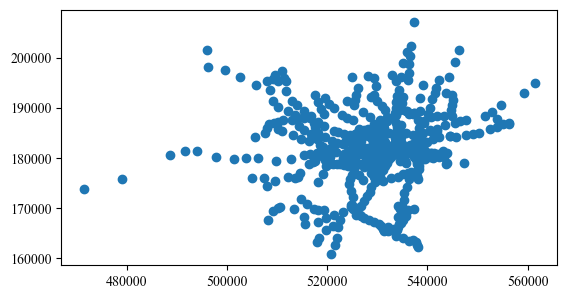

In [1443]:
stations.plot()

### Clean station names

We have multiple points representing one station (for example Paddington has seperate points for different entrances). We will simplify this by using RegEx make the names consistent. 

Once we have cleaned the names we can set the coordinate of these stations to the mean values of the coordinates of all the stations with the same name.

In [1444]:
#get all station names
station_names = {row.id: row['name'] for i, row in stations.iterrows()}

In [1445]:
#clean station names
for k, v in station_names.items():
    if k == 'none':
        continue
    cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)
    
    #note that bank and monument are enconded as one station in our TFL data, so we will do the same
    if cleaned_name in ['Bank', 'Monument']:
        cleaned_name = 'Bank and Monument'
    station_names[k] = cleaned_name
    
stations['name'] = stations['id'].apply(lambda x: station_names[x])

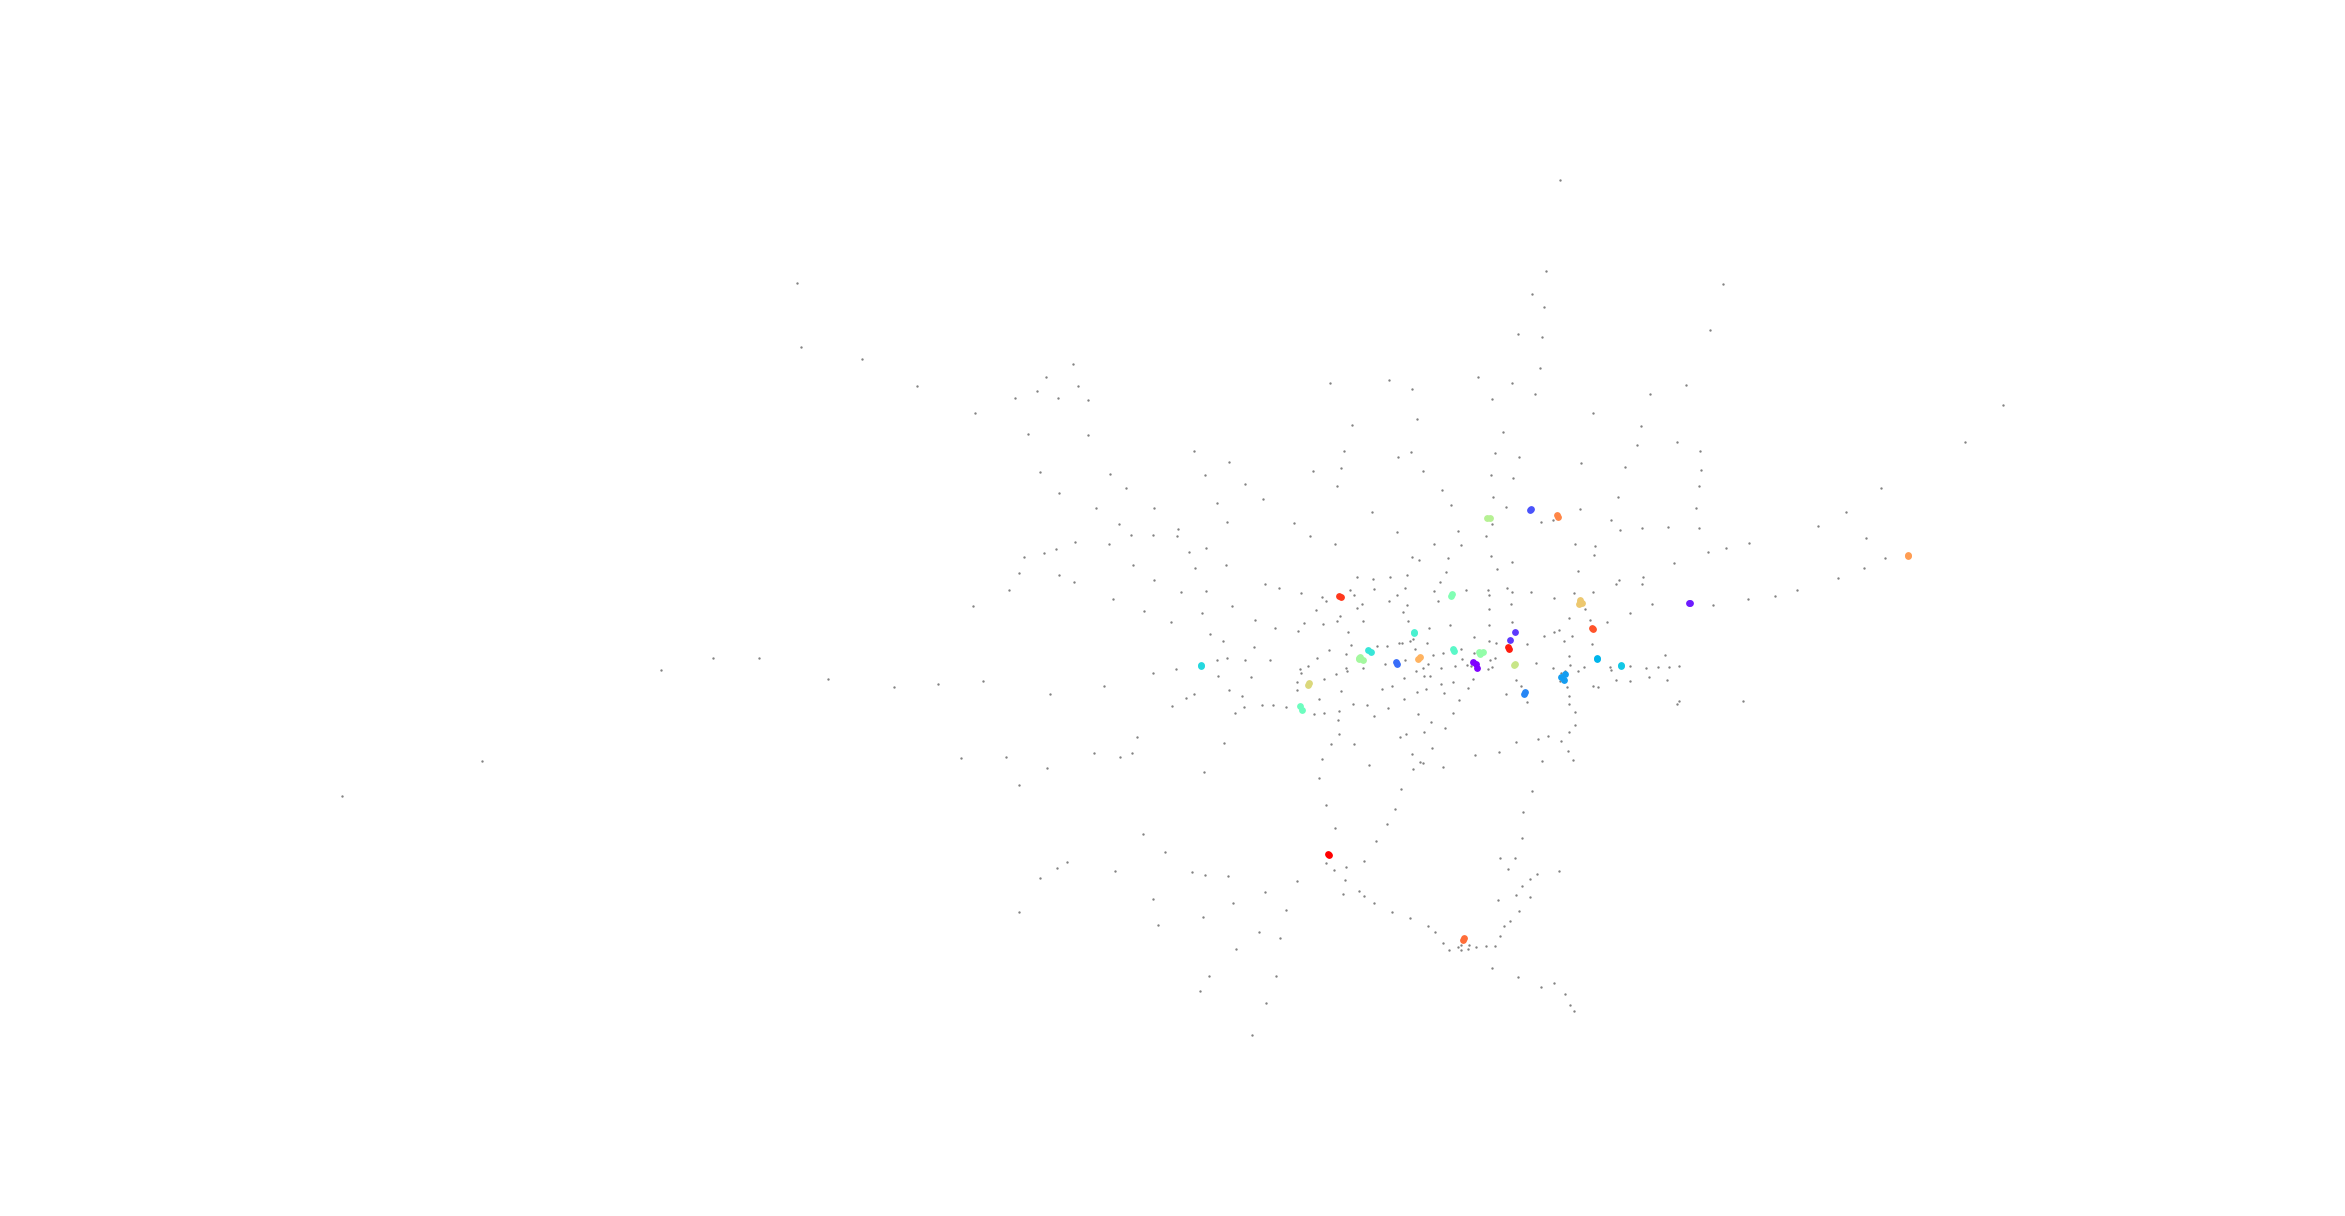

In [1446]:
## we will plot all the stations with multiple points to check there are no errors
fig, ax = plt.subplots(figsize = (30,30))
ax.set_aspect("equal")
ax.axis('off')
ax.margins(0.2)
color = iter(cm.rainbow(np.linspace(0, 1, 29)))
stations.plot(ax=ax, color='grey', markersize=0.5)
for i, group in stations.groupby('name'):
    if len(group)>1:
        group.plot(ax=ax, color = next(color), markersize=15)
plt.show()

**Change position of station to mean of all station with the same name**

In [1447]:
#get position of stations as mean of x, y of stations

#create empty dict to store list of coordinates
pos = {}

#iterate through the stations
for i, station in stations.iterrows():
    xy = station.geometry.coords[0]
    
    #if station already in dict add coordinate to coordinate list
    if station['name'] in pos.keys():
        pos[station['name']].extend([xy])
    #if station is not in the dict add station to dict and set first coordinate in list
    else:
        pos[station['name']] = [xy]

#iterate through our dict and replace coordinate list with mean value
for k, v in pos.items():
    #we set axis to 0 to make sure to take mean of x and y coordinates
    pos[k] = np.mean(v, axis=0)

In [1448]:
#set new geometry
stations['geometry'] = stations['name'].apply(lambda x: Point(pos[x]))

<Axes: >

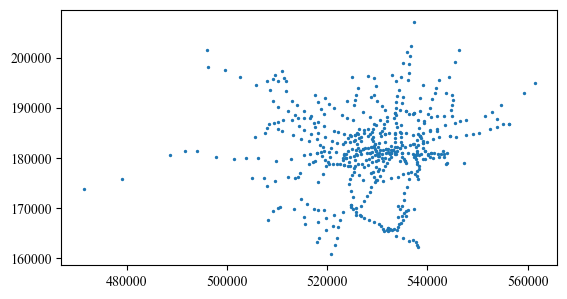

In [1449]:
#check plot to make sure there are no errors
stations.plot(markersize=2)

### Lines file

In [1450]:
lines.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        701 non-null    object  
 1   lines     701 non-null    object  
 2   geometry  701 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 16.6+ KB


In [1451]:
lines.head()

,id,lines,geometry
0,LeaValleyLine1,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (534726.021 182339.910, 534747.550 ..."
1,LeaValleyLine2,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (534826.495 183293.130, 534820.978 ..."
2,LeaValleyLine3,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (534783.192 184262.624, 534785.835 ..."
3,LeaValleyLine4,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (534530.346 185136.490, 534525.951 ..."
4,LeaValleyLine5,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (533996.588 186186.930, 533979.709 ..."


<Axes: >

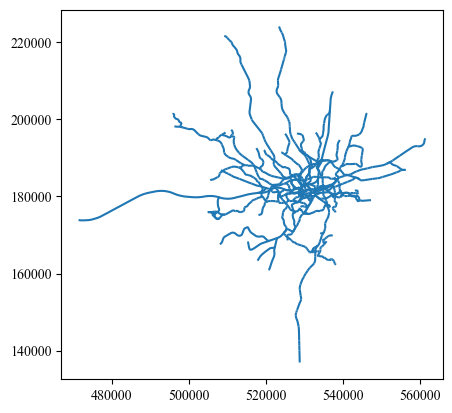

In [1452]:
lines.plot()

### Get all line names

We can see from our lines geodataframe that one geometry can represent multiple lines (for example one for the circle line and another for hammersmith and city) that go between the same stations. 

Let's work each line seperately to make cleaning and checking the data easier. 

In [1453]:
#get all line types as a list and subset geoms by lines
line_names  = lines.lines.apply(lambda x: [x['name'] for x in json.loads(x)] )
line_names = list(set([item for sublist in line_names for item in sublist]))
line_names

['Waterloo & City',
 'East London',
 'Thameslink 6tph line',
 'London Overground',
 'Central',
 'Jubilee',
 'Bakerloo',
 'Metropolitan',
 'Emirates Air Line',
 'Hammersmith & City',
 'Crossrail 2',
 'TfL Rail',
 'Circle',
 'Northern',
 'Tramlink',
 'District',
 'Piccadilly',
 'DLR',
 'Victoria',
 'Crossrail']

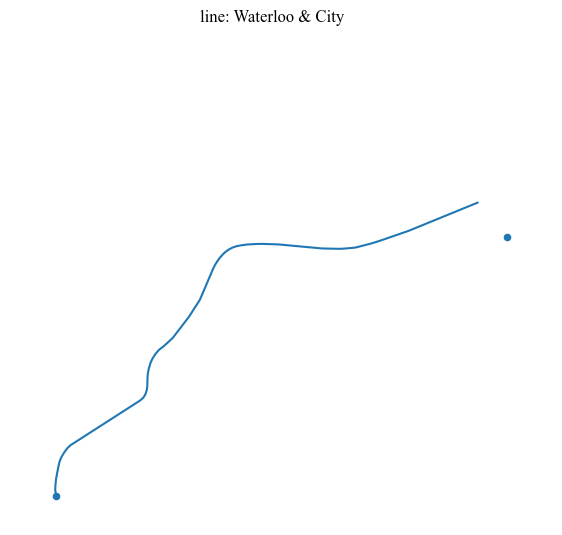

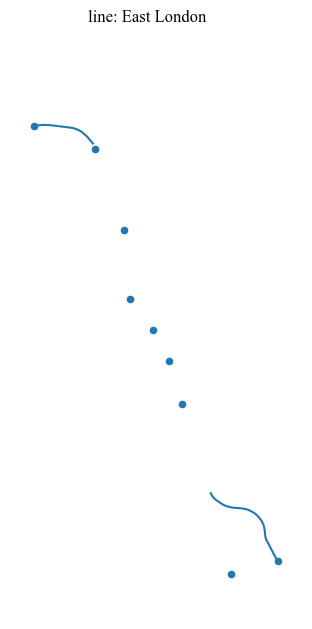

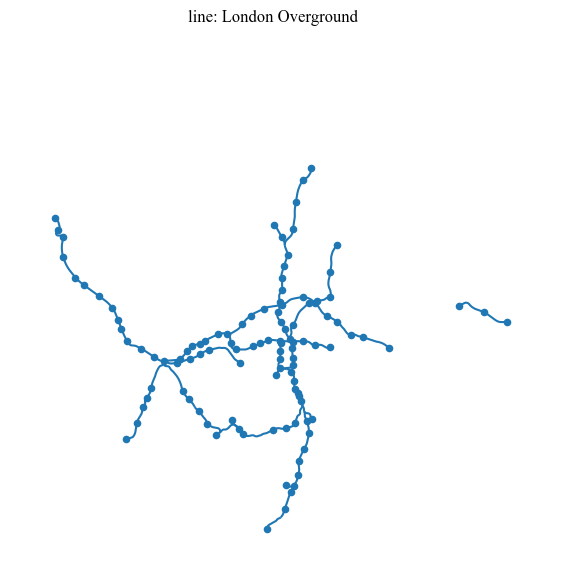

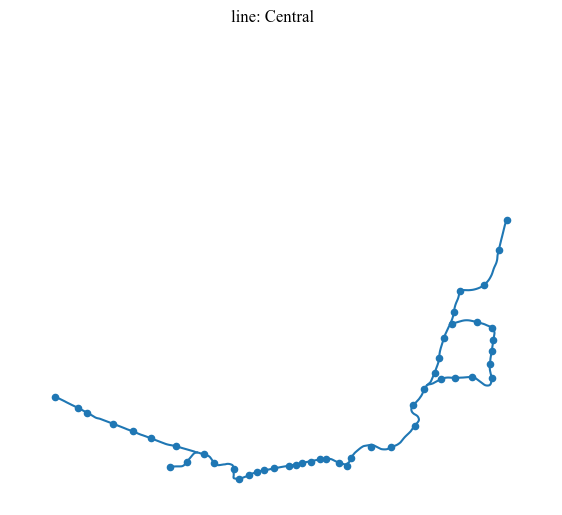

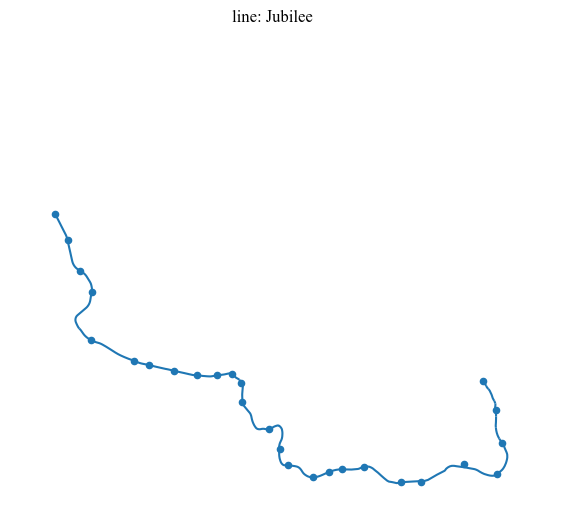

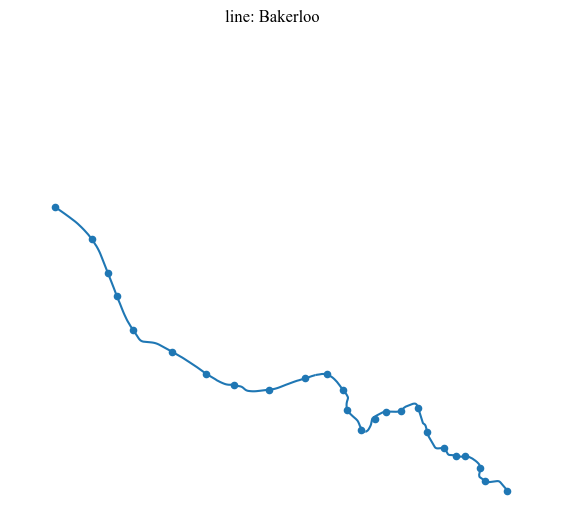

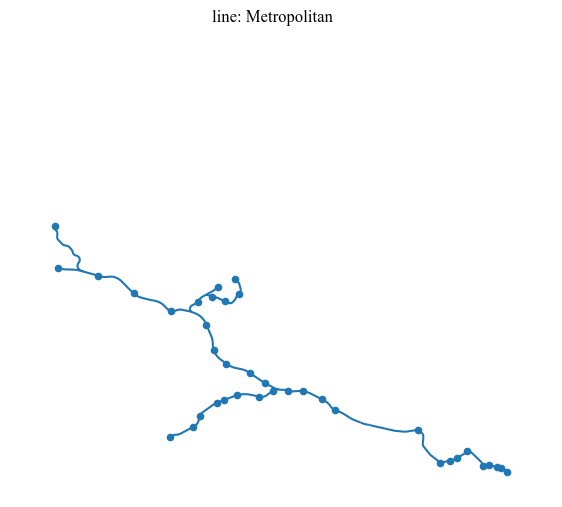

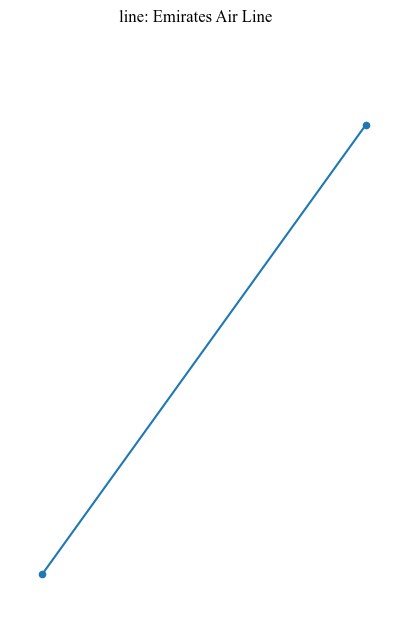

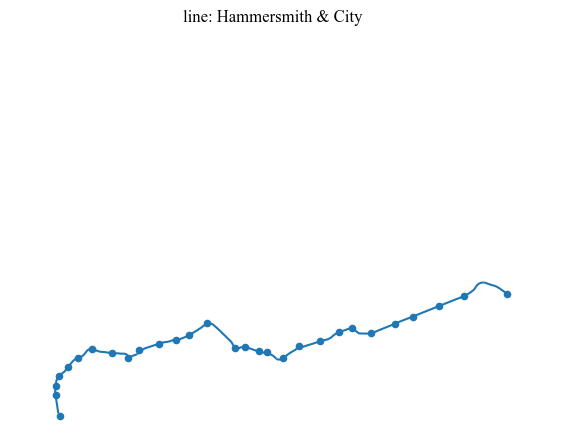

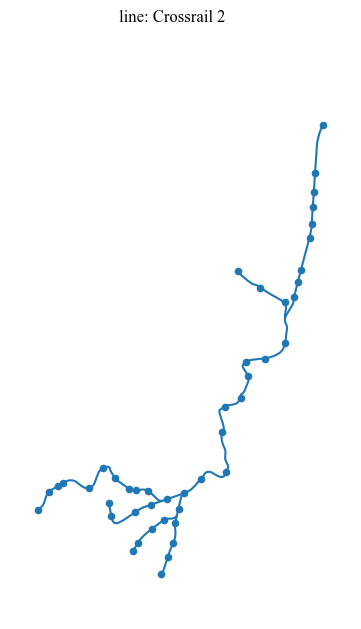

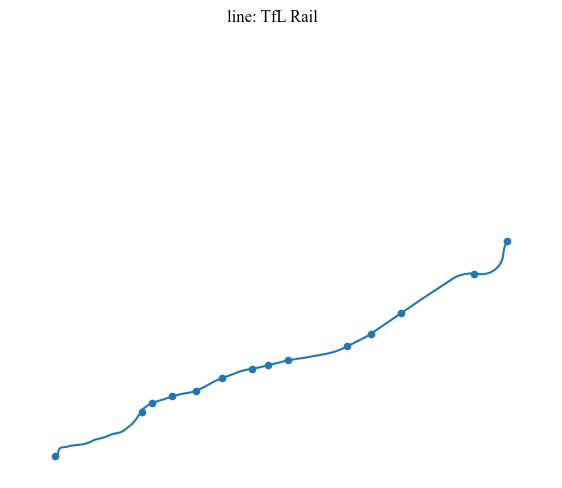

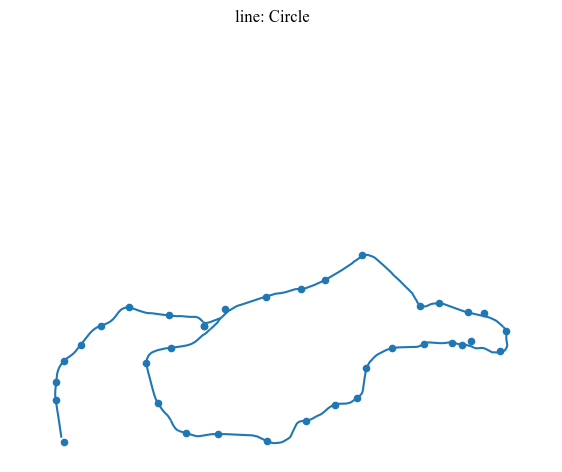

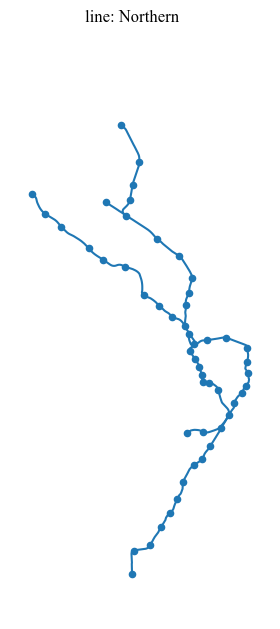

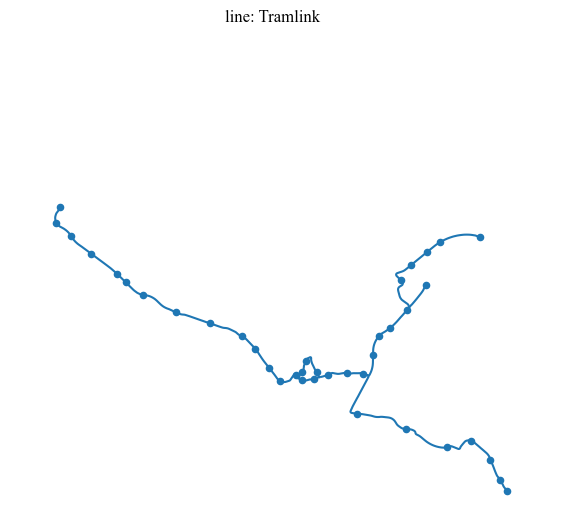

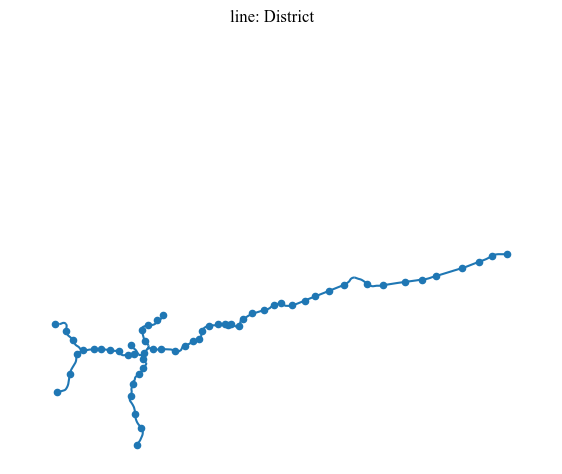

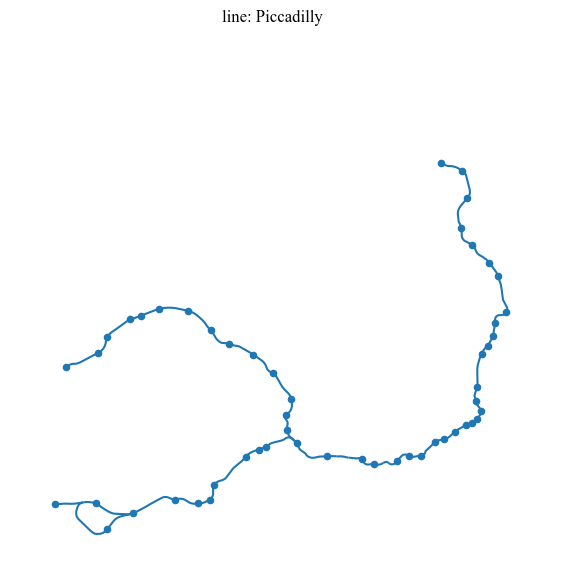

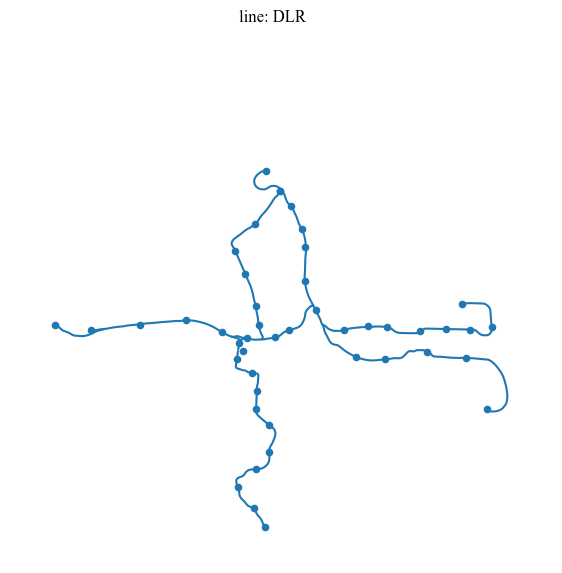

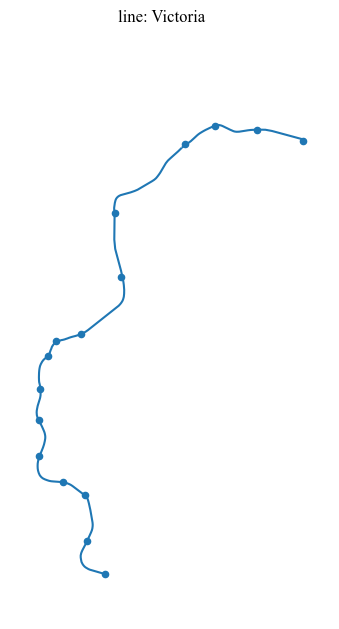

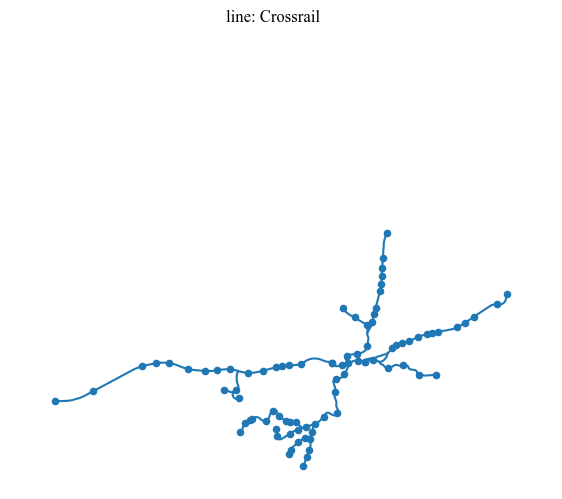

In [1454]:
# check the data for each line
for line in line_names:
    #I'm removing thameslink 6tph line because there are not corresponding stations in station file
    if line == 'Thameslink 6tph line':
        continue
    fig, ax = plt.subplots(figsize = (7,7))
    fig.suptitle(f'line: {line}')
    ax.set_aspect("equal")
    ax.axis('off')
    ax.margins(0.1)
    temp_lines = lines[lines.lines.str.contains(line)]
    base = temp_lines.plot(ax=ax)
    temp_stations = stations[stations.lines.str.contains(line)]
    temp_stations.plot(ax=base, markersize=20)
    plt.show()

In [1455]:
#We can see that east london line is incomplete
#digging into this however we notice that it's because east london is actually part of the overground
#merge East London line and London Overground since they are one line
lines.lines = lines.lines.str.replace('East London', 'London Overground')
stations.lines = stations.lines.str.replace('East London', 'London Overground')

In [1456]:
#Our TFL data doesn't include tramlink, emirates air lines, and crossrail is still in construction (except not really)
#exclude the lines that we are not going to use
excluded_lines = ['Thameslink 6tph line', 'East London', 'Crossrail 2', 'Emirates Air Line', 'Crossrail', 'Tramlink']

## Create seperate graphs for each line and then join

Since we don't have properly constructed line geometries because:
* there are discontinuities in the line geometries
* a line between two stations can actually be composed of more than one geometry

We will construct geometric graphs (meaning graphs just from the line geometries where nodes are coordinates that define the line geometry). It's easy to fix the discontinuities in this manner because the can be thought of as nodes with degree = 1 that have another node with degree = 1 within a threshold distance. 

Once we have these discontinuties fixed we can use these geometric graphs to construct proper geometries between stations by taking the shortest paths within these networks starting from the node closest to the origin station and ending in the node closest to the destination station. The shortest path will then be a list of coordinates that define the line geometry between the two stations. 

Waterloo & City


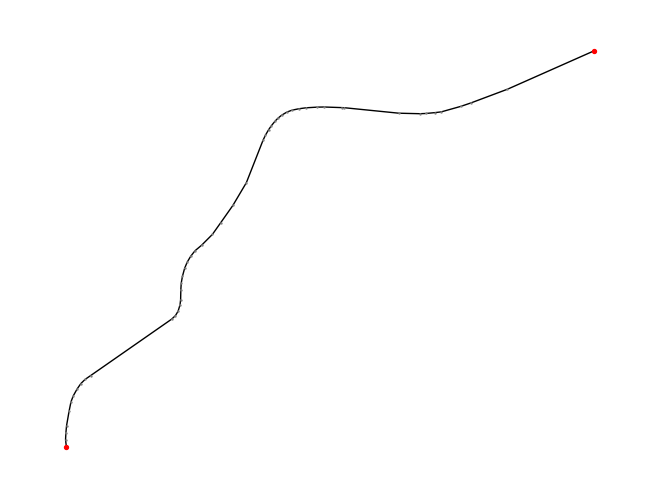

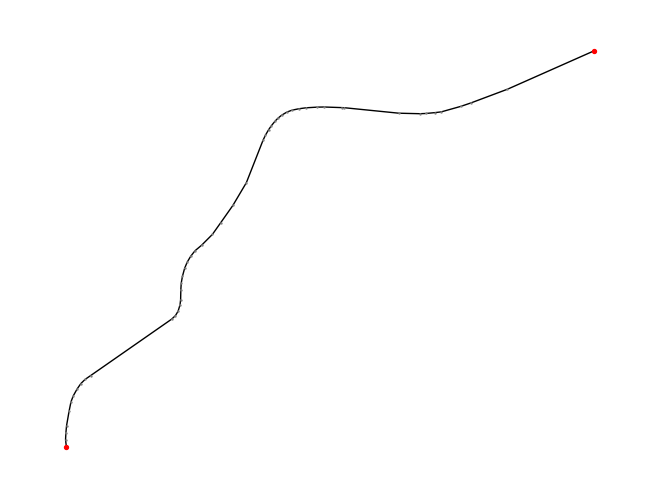

1
London Overground


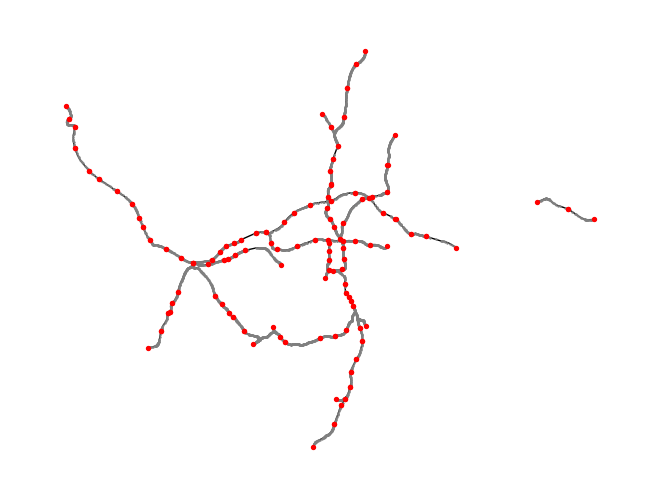

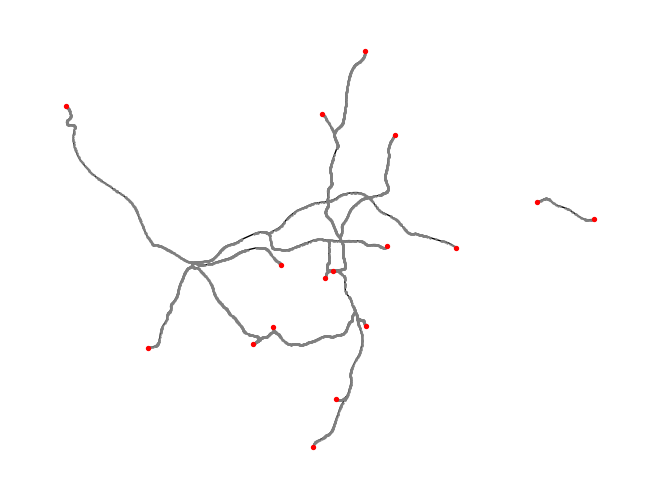

3
Central


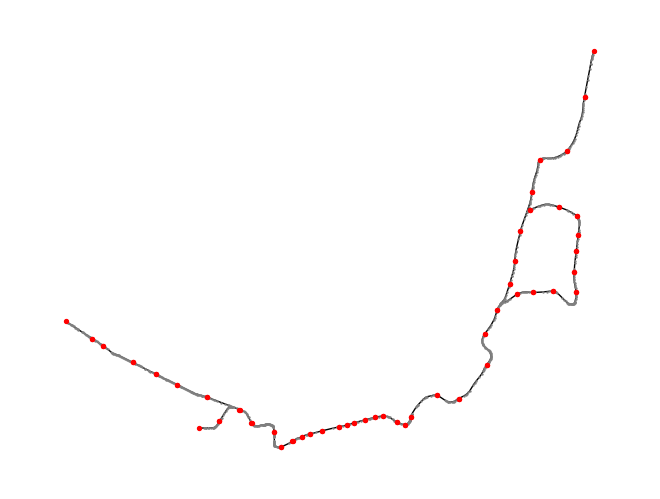

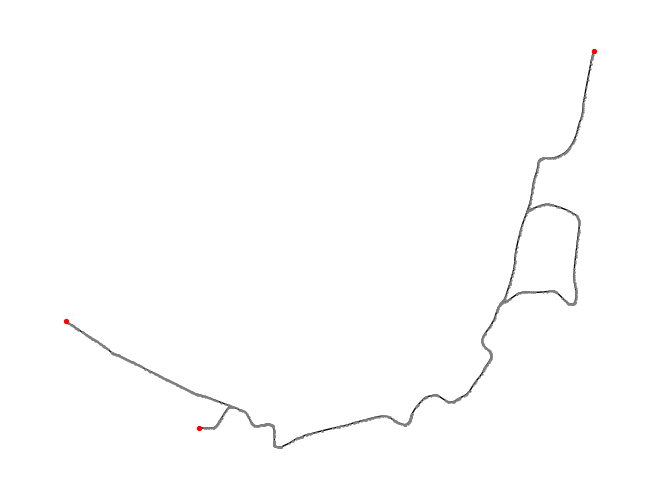

1
Jubilee


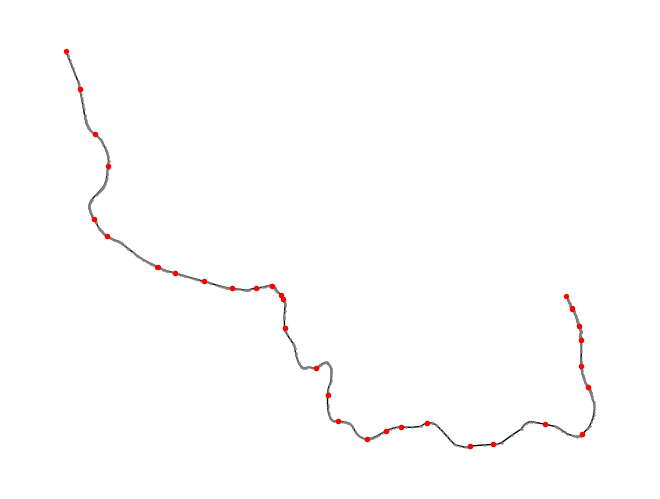

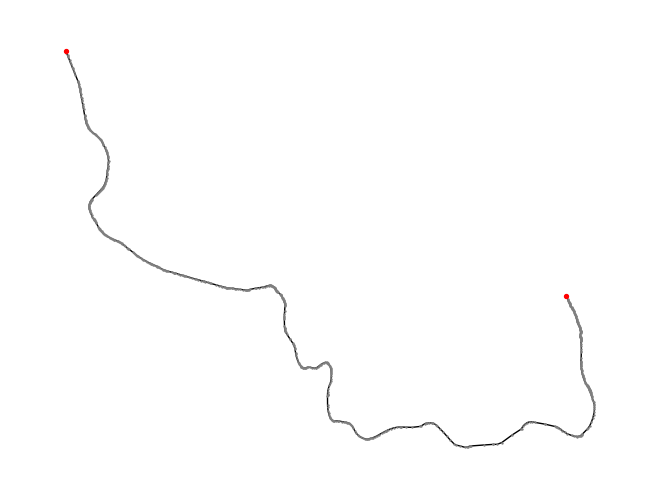

1
Bakerloo


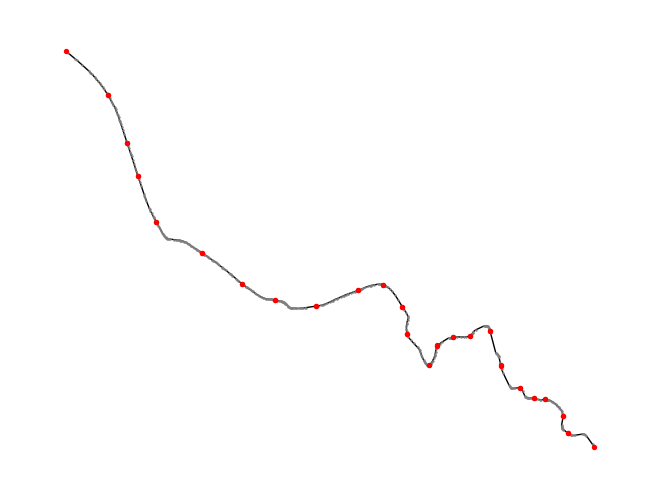

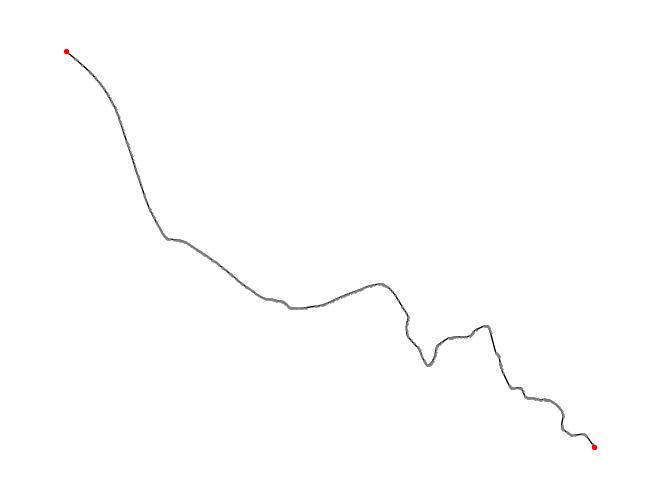

1
Metropolitan


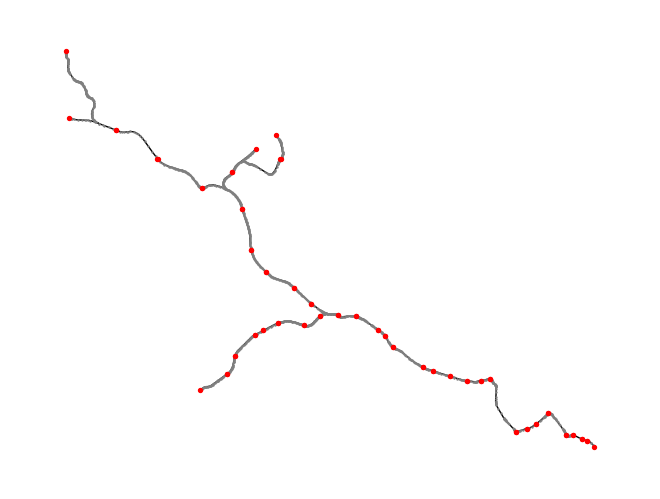

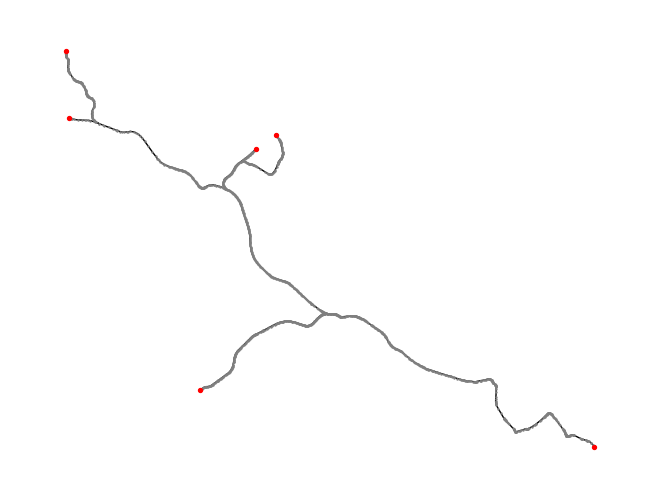

1
Hammersmith & City


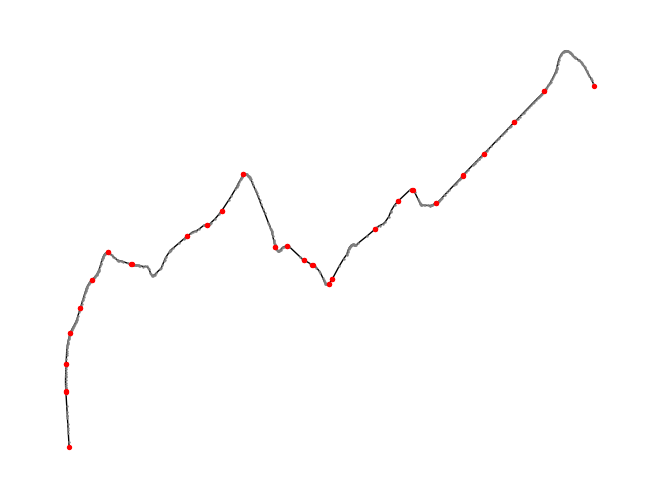

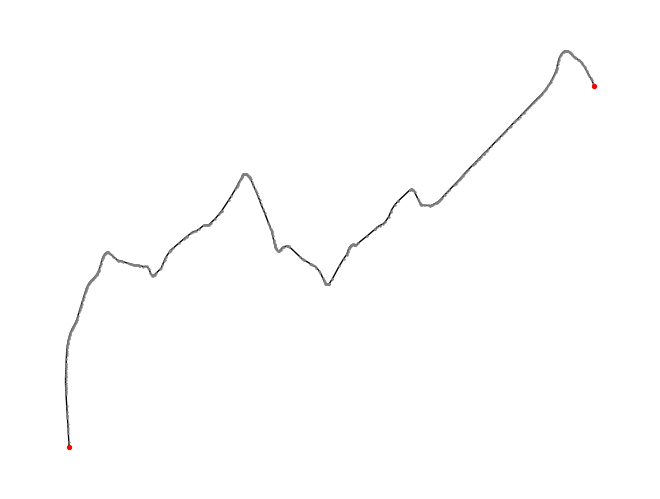

1
TfL Rail


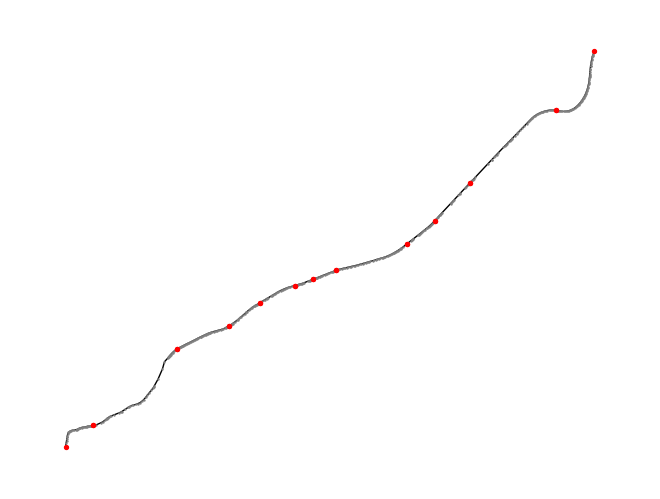

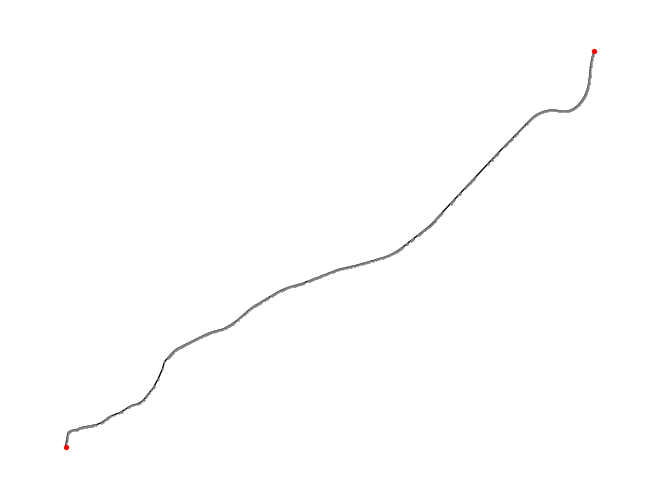

1
Circle


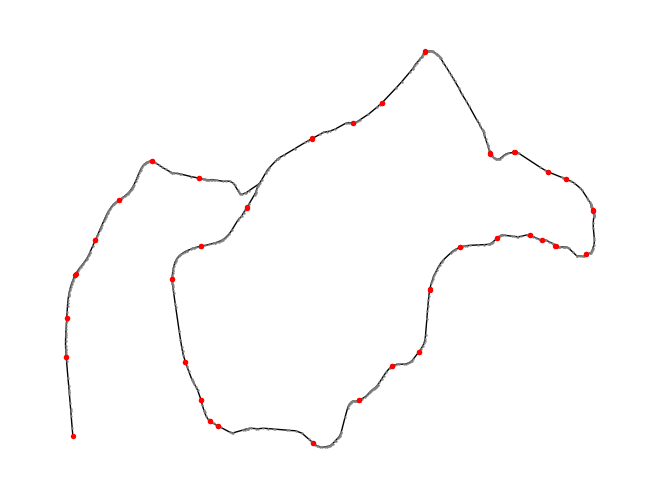

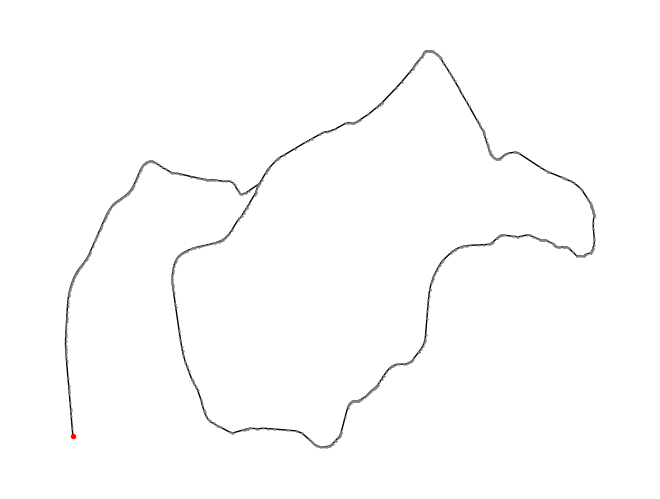

1
Northern


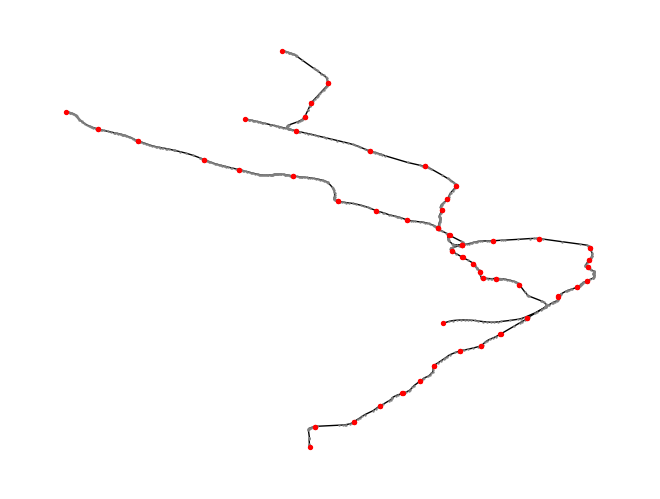

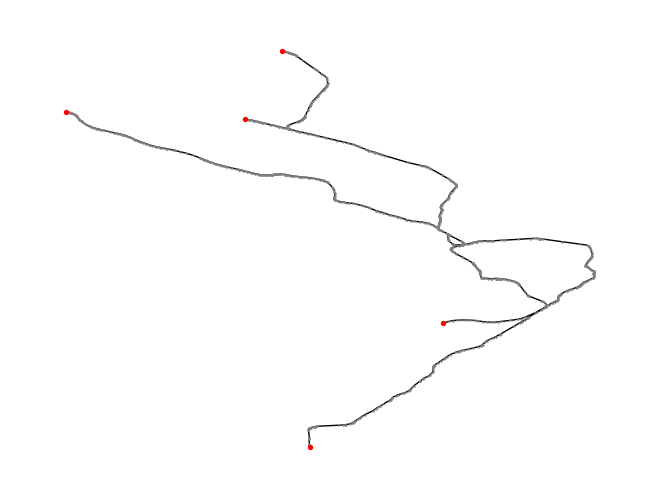

1
District


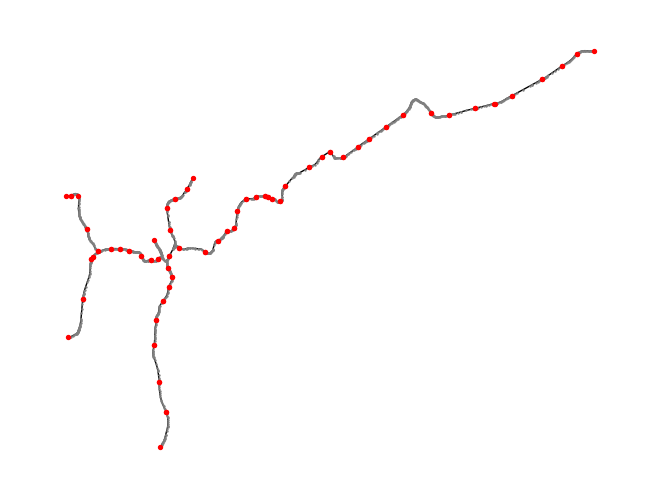

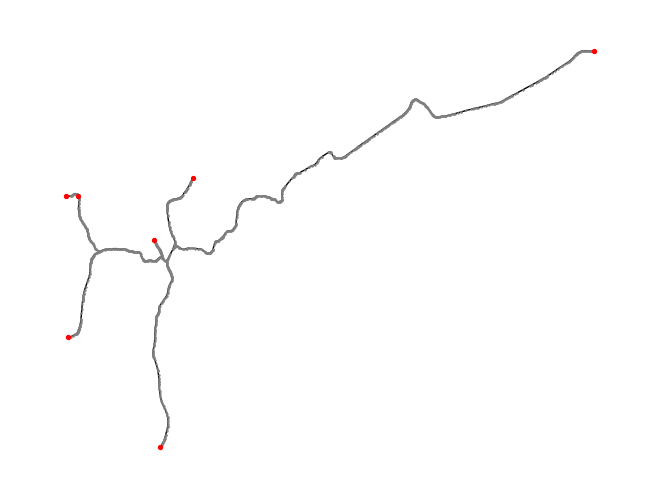

1
Piccadilly


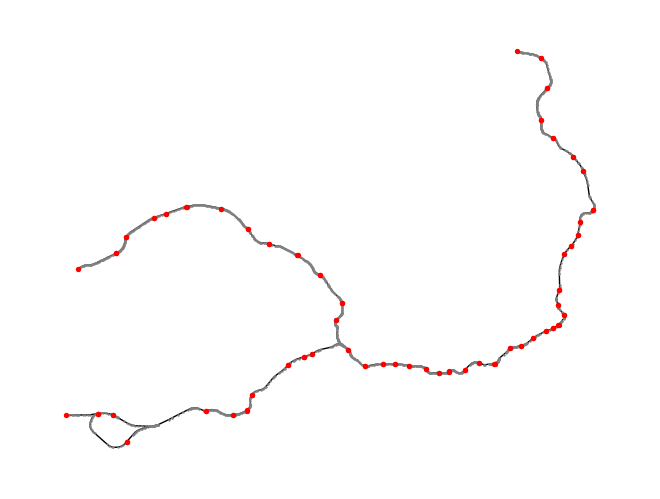

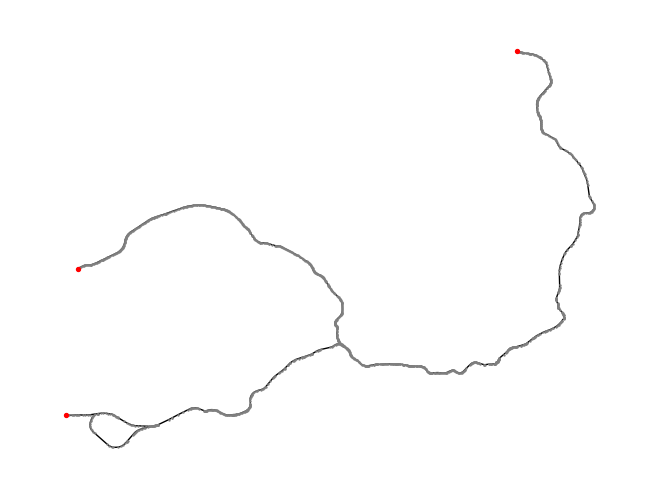

1
DLR


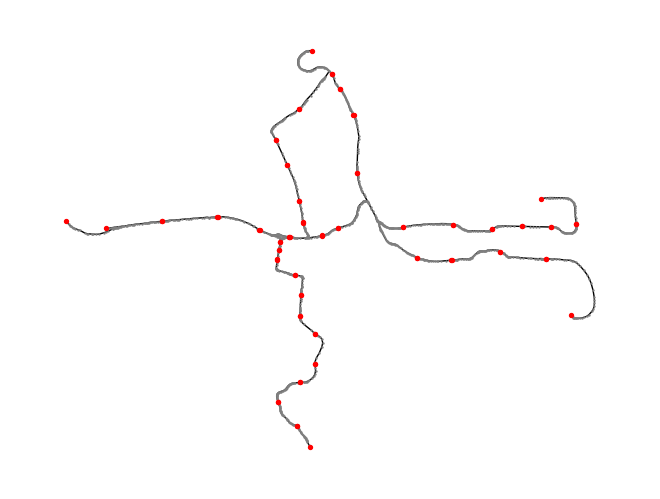

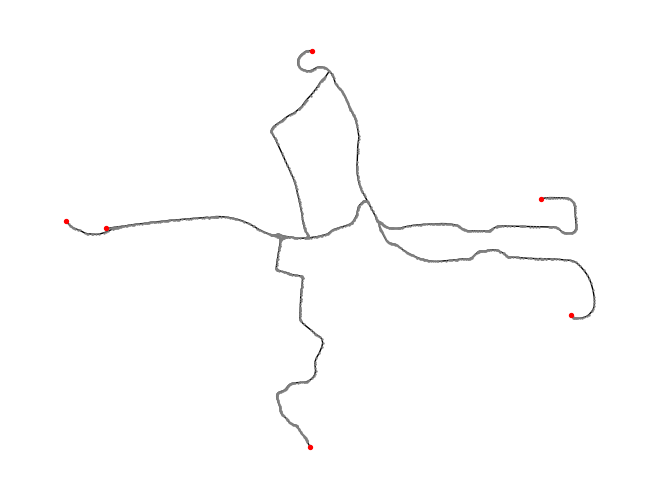

1
Victoria


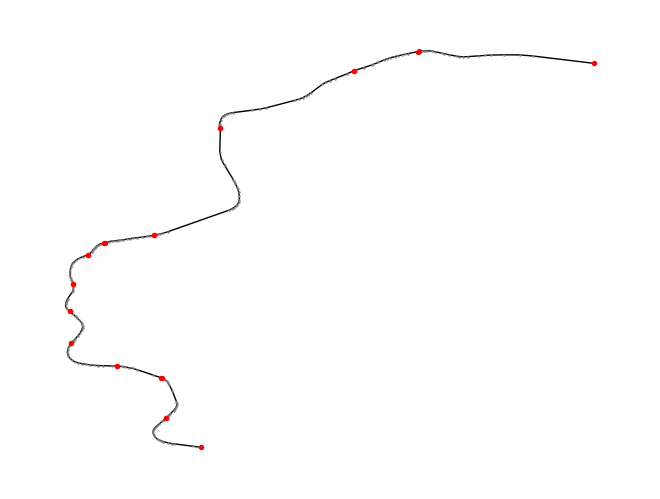

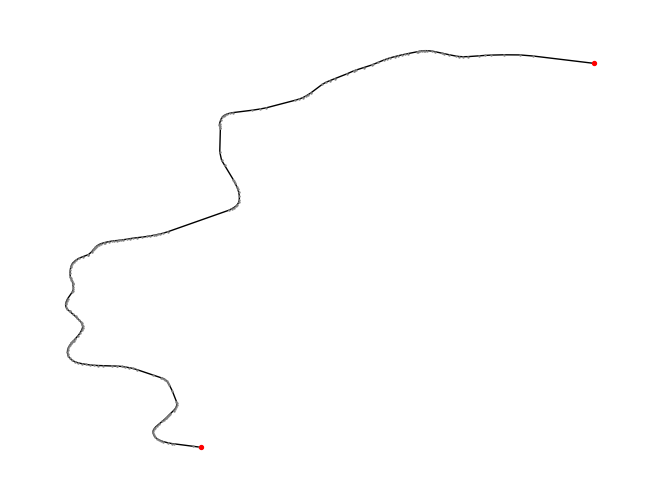

1


In [1457]:
#create an empty dict to hold our geometric graphs
geometric_graphs = {}

#iterate through each line individually
for line_name in line_names:
    #skip lines that we won't be using
    if line_name in excluded_lines :
        continue
    print(line_name)
    
    #subset our line and station files for the ones the belong to a specific line
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #create empty graph
    G= nx.Graph()
    
    #iterate through our line geometries
    for i, line in temp_lines.iterrows():
        #get list of coordinates that define our line
        _l = list(line.geometry.coords)

        #add coordinates as edges
        G.add_edges_from(list(zip(_l,_l[1:])))
    
    #remove any self loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    #the position of the node is the name of the node
    #let's extract this to plot our graph
    pos = {n: n for n in G.nodes()}
    
    # get degree one nodes
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #let's plot our graph and all degree one nodes
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    
    #get distance between all points of 1-degree, this will be a matrix
    dist = distance.cdist(k1, k1)
    
    #add edges between points that are close
    for j in range(dist.shape[0]-1):
        temp = dist[j][j+1:]
        #get index of closest node
        i_min = np.argmin(temp)
        if dist[j][i_min+j+1]<50:
            G.add_edge(k1[j],k1[i_min+j+1])
    
    #recalculate degree
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #plot new graph
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    print(nx.number_connected_components(G))
    #store graph in dictionary
    geometric_graphs[line_name] = G


Now that we have these geometric graphs we can create our final graph by using the data in the lines attribute in our lines geodataframe that contains origin and destination station. We can then use our geometric graph and find the shortest route to create our line geometries and find the length of the lines. 

We will store this information in a dataframe that we can use to create our final graph

In [1458]:
#create a dataframe with all geometries from all valid lines
#this list will contain a dictionary for each edge in our graph that contains
# node pairs, line name, and a geometry (this is just for quick visualization purposes and will be replaced by true geometry)
edge_list = []
def _has_ids(k):
    #helper function to check if line contains id of start and end station
    if ('start_sid' in k.keys()) and ('end_sid' in k.keys()):
        return True
    else:
        return False

#iterate through each line seperately 
for line_name in line_names:
    if line_name in excluded_lines :
        continue
        
    #subset lines and stations
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #for each line in our subset dataframe get each origin and destination pair
    for i, line in temp_lines.iterrows():
        for k in json.loads(line.lines):
            if k['name'] == line_name:
                if _has_ids(k):
                    #get start and end station ids
                    start_id = k['start_sid']
                    end_id = k['end_sid']

                    #get info of start and end station
                    start_station = temp_stations[(temp_stations.id == start_id) | (temp_stations.altmodeid == start_id)].values
                    end_station = temp_stations[(temp_stations.id == end_id) | (temp_stations.altmodeid == end_id)].values
                    
                    #if no matching station exist, let's just take the starting and ending coordinate of the line for now
                    if len(start_station) >= 1 and len(end_station) >=1:
                        s_geom = start_station[0][-1].coords[0]
                        e_geom = end_station[0][-1].coords[0]
                        edge_list.append({
                            'line_name': line_name,
                            'start_id': start_id,
                            'end_id': end_id,
                            'geometry': LineString([s_geom, e_geom])
                        })

,line_name,start_id,end_id,geometry
0,Waterloo & City,940GZZLUWLO,940GZZLUBNK,"LINESTRING (530974.091 179921.099, 532821.106 ..."
1,London Overground,910GCAMHTH,910GBTHNLGR,"LINESTRING (534826.877 183290.997, 534856.070 ..."
2,London Overground,910GCAMHTH,910GLONFLDS,"LINESTRING (534826.877 183290.997, 534782.941 ..."
3,London Overground,910GLONFLDS,910GHAKNYNM,"LINESTRING (534782.941 184260.470, 534531.043 ..."
4,London Overground,910GHAKNYNM,910GRCTRYRD,"LINESTRING (534531.043 185134.568, 533997.280 ..."


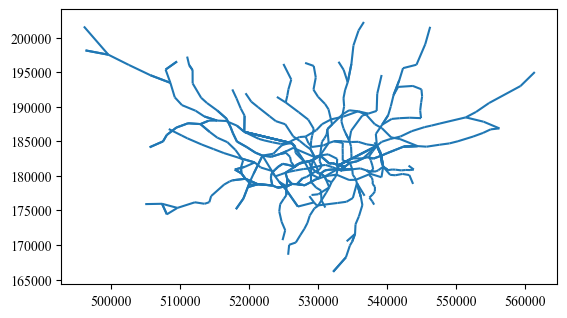

In [1459]:
#turn our dictionary list into a geopandas df to quickly plot and sanity check our work
edge_gdf = gpd.GeoDataFrame(edge_list)
edge_gdf.crs = lines.crs
edge_gdf.plot()
edge_gdf.head()

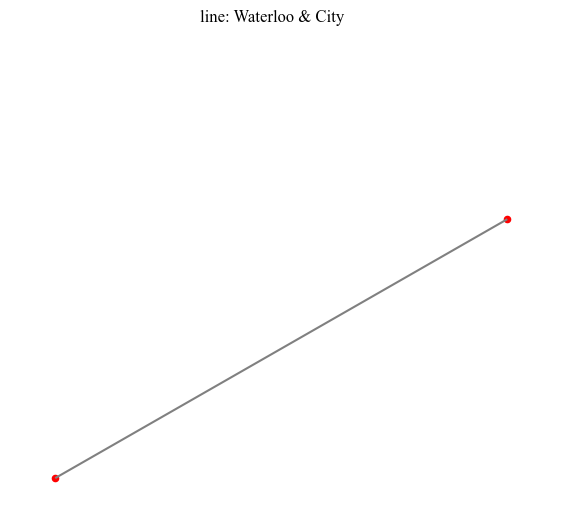

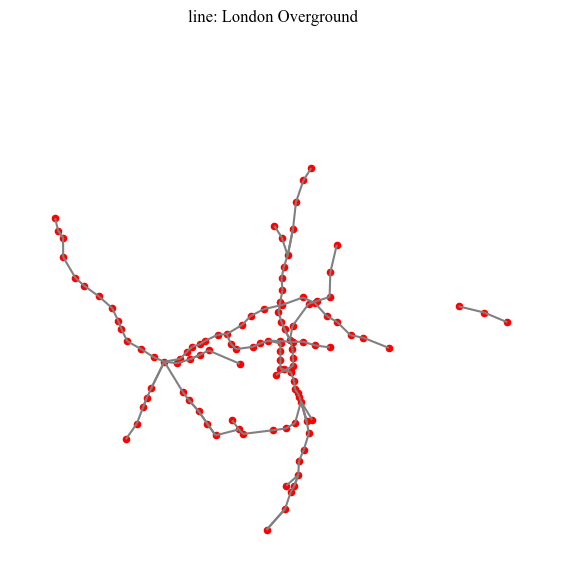

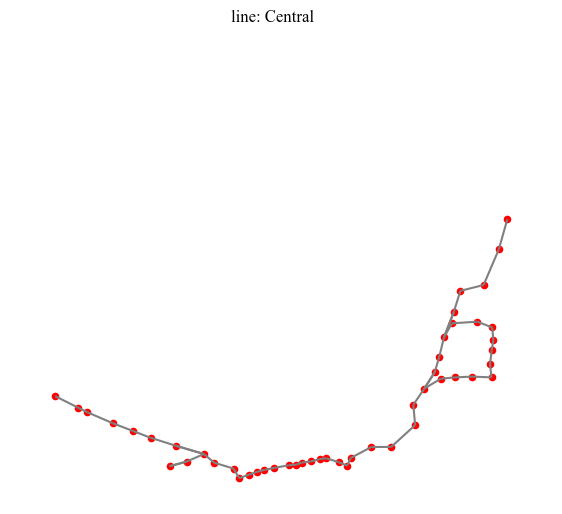

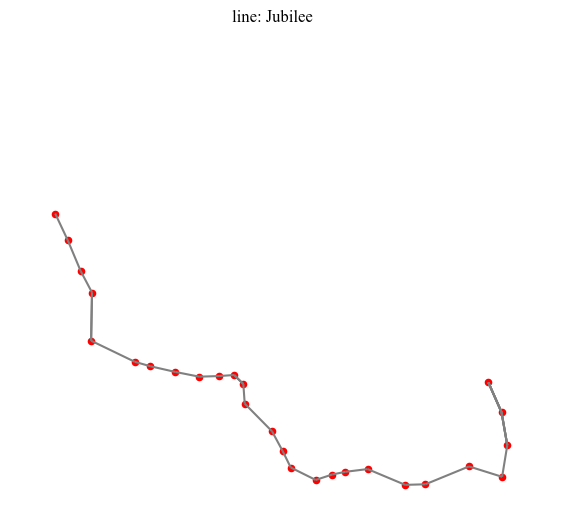

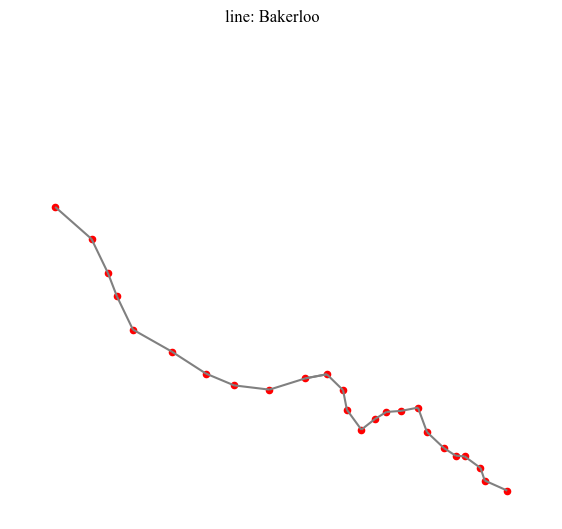

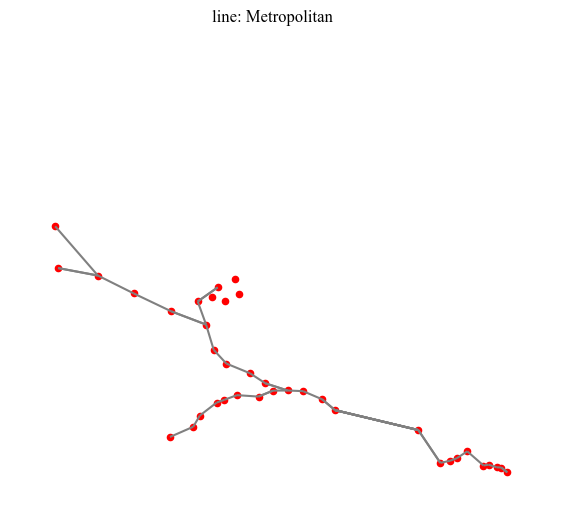

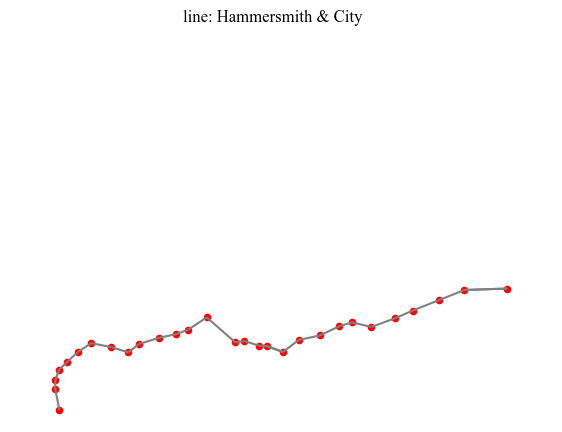

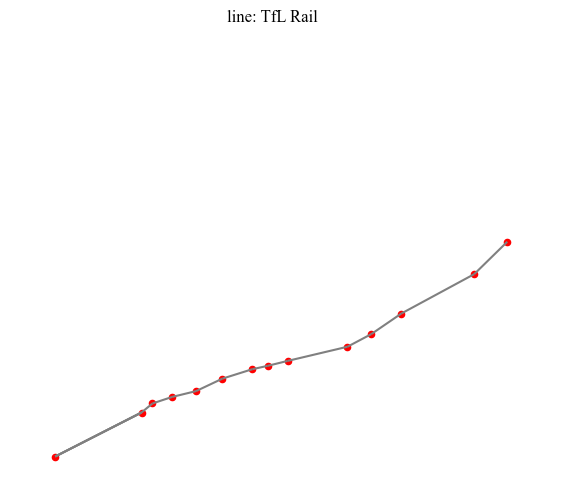

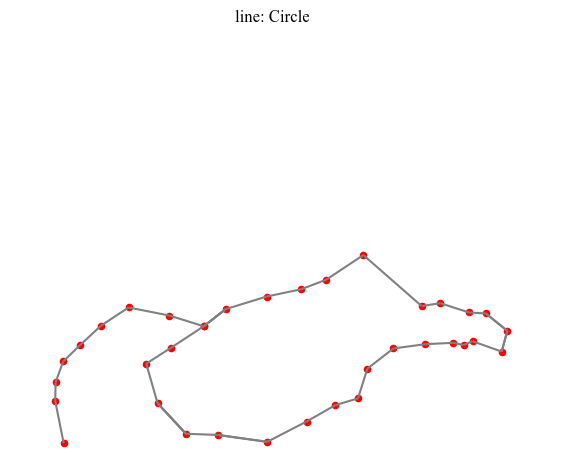

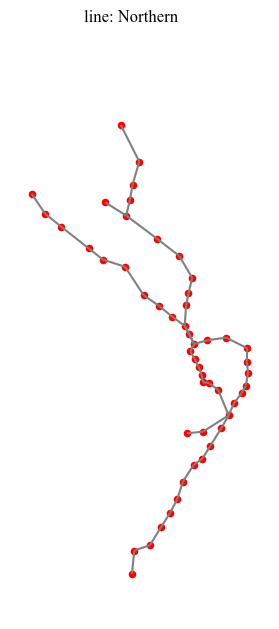

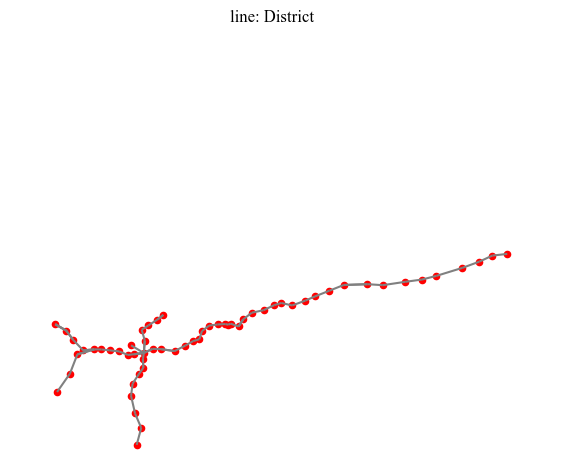

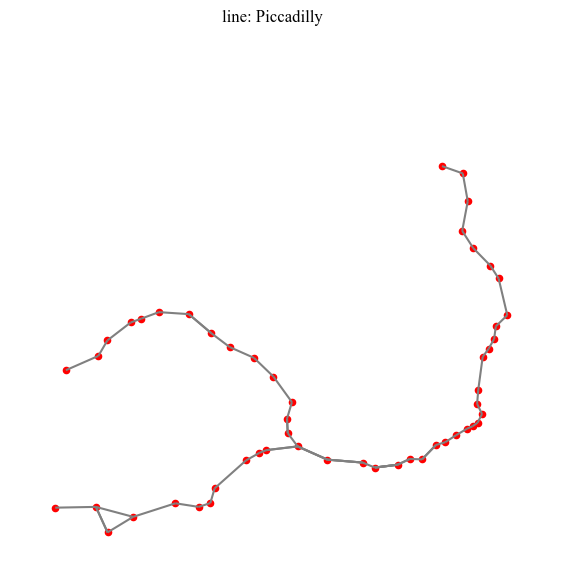

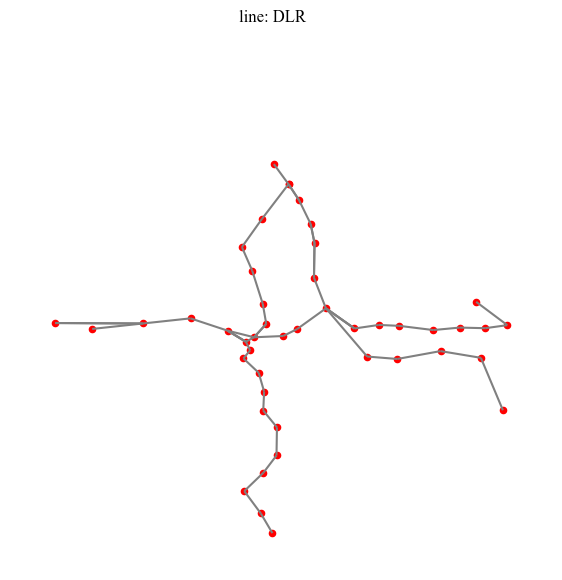

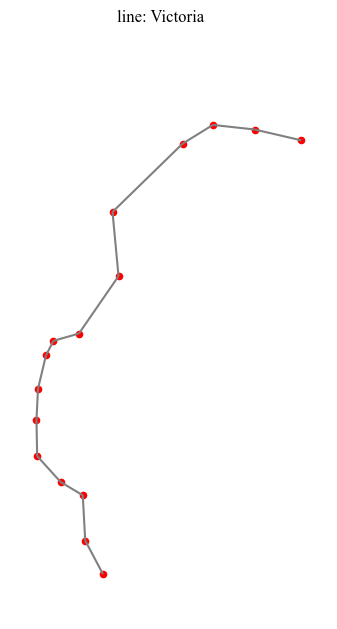

In [1460]:
### Add geometry information back into the graph
for line_name in line_names:
    if line_name in excluded_lines :
        continue
    temp_lines = edge_gdf[edge_gdf.line_name == line_name]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #let's plot our lines so we can check them
    fig, ax = plt.subplots(figsize = (7,7))
    fig.suptitle(f'line: {line_name}')
    ax.set_aspect("equal")
    ax.axis('off')
    ax.margins(0.1)
    
    base = temp_lines.plot(ax=ax, color='grey')
    temp_stations.plot(ax=base, markersize=20, color='red')
    plt.show()
    
    #add real geometry back
    for i, edge in temp_lines.iterrows():
        #get start and end of line coordinates
        start = edge.geometry.coords[0]
        end = edge.geometry.coords[-1]
        
        #let's get all the coordinates in our geometric graph
        nodes = list(geometric_graphs[line_name].nodes)
        
        #find nearest node in graph to origin and destination
        s_dist = distance.cdist([start], nodes)[0]
        s_i = np.argmin(s_dist)
        source= nodes[s_i]
        
        t_dist = distance.cdist([end], nodes)[0]
        t_i = np.argmin(t_dist)
        target= nodes[t_i]
        
        #get shortest path
        sp = nx.shortest_path(geometric_graphs[line_name], source, target)
        
        #make into geometry
        #notice how I'm also adding the start and end coordinates to the line definition
        #this fixes the problem of stations and lines not matching up
        geometry = LineString([start] + sp + [end])
        edge_gdf.loc[i, 'geometry'] = geometry

<Axes: >

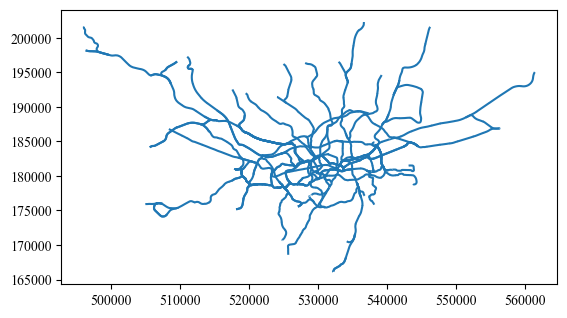

In [1461]:
#plot to sanity check
edge_gdf.plot()

In [1462]:
#let's store the length of the real geometry
edge_gdf['length'] = edge_gdf.geometry.length

In [1463]:
#this is our resulting dataframe
edge_gdf.head()

,line_name,start_id,end_id,geometry,length
0,Waterloo & City,940GZZLUWLO,940GZZLUBNK,"LINESTRING (530974.091 179921.099, 530973.801 ...",2542.954444
1,London Overground,910GCAMHTH,910GBTHNLGR,"LINESTRING (534826.877 183290.997, 534827.512 ...",831.871588
2,London Overground,910GCAMHTH,910GLONFLDS,"LINESTRING (534826.877 183290.997, 534827.512 ...",979.416986
3,London Overground,910GLONFLDS,910GHAKNYNM,"LINESTRING (534782.941 184260.470, 534782.678 ...",926.012712
4,London Overground,910GHAKNYNM,910GRCTRYRD,"LINESTRING (534531.043 185134.568, 534531.871 ...",1201.022377


In [1464]:
#let's replace the ids with the actual name
#get all station names
station_names_2 = {row.altmodeid: row['name'] for i, row in stations.iterrows() if row.altmodeid != None}
station_names.update(station_names_2)

In [1465]:
edge_gdf['start_id'] = edge_gdf['start_id'].apply(lambda x: station_names[x])
edge_gdf['end_id'] = edge_gdf['end_id'].apply(lambda x: station_names[x])

In [1466]:
edge_gdf.head()

,line_name,start_id,end_id,geometry,length
0,Waterloo & City,Waterloo,Bank and Monument,"LINESTRING (530974.091 179921.099, 530973.801 ...",2542.954444
1,London Overground,Cambridge Heath,Bethnal Green,"LINESTRING (534826.877 183290.997, 534827.512 ...",831.871588
2,London Overground,Cambridge Heath,London Fields,"LINESTRING (534826.877 183290.997, 534827.512 ...",979.416986
3,London Overground,London Fields,Hackney Downs,"LINESTRING (534782.941 184260.470, 534782.678 ...",926.012712
4,London Overground,Hackney Downs,Rectory Road,"LINESTRING (534531.043 185134.568, 534531.871 ...",1201.022377


In [1467]:
#now we can use this to create our network!
G = nx.from_pandas_edgelist(edge_gdf, source = 'start_id', target='end_id', edge_attr=['length', 'line_name'])

{'Metropolitan', 'TfL Rail', 'Circle', 'Waterloo & City', 'Northern', 'DLR', 'District', 'London Overground', 'Victoria', 'Central', 'Jubilee', 'Hammersmith & City', 'Piccadilly', 'Bakerloo'}


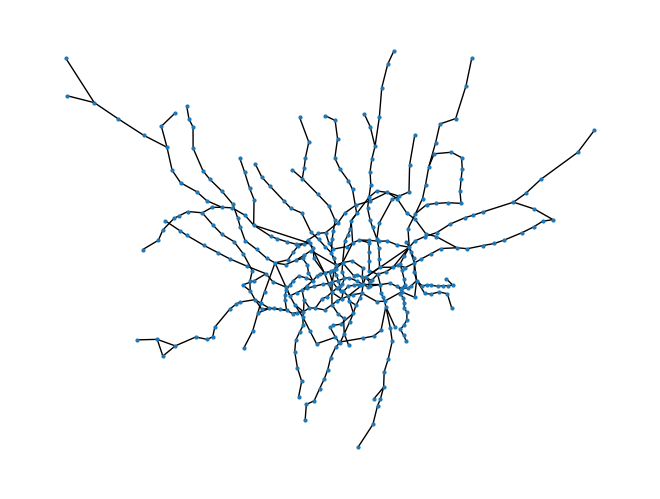

In [1468]:
#let's plot
#notice that even though we created the real geometries, the graph still plots just straight line
#this is because networkx doesn't have a concept of a edge geometry
#however this is ok, since we only need the distance as weights, and that is already an attribute in our graph
pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G.nodes()}
Gcc = nx.connected_components(G)
for n in Gcc:
    G_sub = G.subgraph(n)
    lines = [data['line_name'] for u,v, data in G_sub.edges(data=True)]
    print(set(lines))
    nx.draw(G_sub, pos, node_size=4)
    plt.show()

In [1469]:
#save position to graph
nx.set_node_attributes(G, pos, 'coords')

### Sanity check our network

In [1470]:
#check that all distances are greater or equal to euclidean distance
for u,v, data in G.edges(data=True):
    assert(data['length'] >= distance.euclidean(pos[u], pos[v]))

In [1471]:
#if want to know what is the maximum distance between stations
max(dict(G.edges).items(), key=lambda x: x[1]['length'])

(('Wembley Park', 'Finchley Road'),
 {'length': 7266.37392749648, 'line_name': 'Metropolitan'})

In [1472]:
#if want to know to which stations Baker Street is directly connected to
Baker_Street = [(u,v) for  u,v in G.edges() if u == 'Baker Street' or v == 'Baker Street']
Baker_Street

[('Bond Street', 'Baker Street'),
 ('Baker Street', "St. John's Wood"),
 ('Baker Street', 'Marylebone'),
 ('Baker Street', "Regent's Park"),
 ('Baker Street', 'Great Portland Street'),
 ('Baker Street', 'Finchley Road'),
 ('Baker Street', 'Edgware Road')]

In [1473]:
#We can also check the degree of the nodes in our network and check that they make sense
deg_london = nx.degree(G)

In [1474]:
df = pd.DataFrame(index = dict(deg_london).keys())
df['degree'] = dict(deg_london).values()

In [1475]:
df.sort_values('degree', ascending =False).head(20)

,degree
Stratford,9
Bank and Monument,8
Baker Street,7
King's Cross St. Pancras,7
Waterloo,6
Earl's Court,6
Canning Town,6
Green Park,6
Oxford Circus,6
Liverpool Street,6


### Merge Network with OD data

ok, we are almost done!

We have processed our raw data, now we need to combine the two (TLF OD and our Network). For this we need two types of merge:

1. add flows as weights to the network (to be able to calculate disruptions to the network)
2. create OD with distance for our spatial interaction models (for our spatial interaction models)

In [1476]:
# Read in the edgelist file from csv
weighted_network = pd.read_csv("C:/Users/86180/Desktop/US/cw/london_flows.csv")

In [1477]:
#check that our OD data and network data match
OD_names = set(weighted_network.station_origin.unique())
network_names = set([n for n in G.nodes()])

In [1478]:
network_names.symmetric_difference(OD_names)

{'Battersea Power Station', 'Nine Elms'}

Ok, we have a few stations that don't match up. They are small enough that we can solve this quickly by creating a mapping between names of the stations that we can keep.

* Battersea power station and Nine Elms data doesn't exist in our TFL data because the station wasn't opened when the data was collected. This was an extension of Northern line that opened recently.
* Action Main Line, Hanwell, Hayes & Harlington, Southall, and West Ealing are part of crossrail which we are not considering

In [1479]:
name_map = {
    'Heathrow Terminal 4 EL': 'Heathrow Terminal 4',
    'Heathrow Terminals 123': 'Heathrow Terminals 2 & 3',
    'Heathrow Terminals 2 & 3 EL': 'Heathrow Terminals 2 & 3',
    "Walthamstow Queen's Road": 'Walthamstow Queens Road'
}

In [1480]:
weighted_network.station_origin = weighted_network.station_origin.apply(
    lambda x: name_map[x] if x in name_map.keys() else x
)
weighted_network.station_destination = weighted_network.station_destination.apply(
    lambda x: name_map[x] if x in name_map.keys() else x
)

In [1481]:
#let's filter out the stations that we don't have in our network
OD_names = set(london_OD_AMpeak.station_origin.unique())
_filter = list(network_names.symmetric_difference(OD_names))
_filter

['Hanwell',
 "Walthamstow Queen's Road",
 'Heathrow Terminals 123',
 'Battersea Power Station',
 'Southall',
 'Walthamstow Queens Road',
 'Nine Elms',
 'Hayes & Harlington',
 'Acton Main Line',
 'West Ealing',
 'Heathrow Terminals 2 & 3',
 'Heathrow Terminal 4 EL',
 'Heathrow Terminals 2 & 3 EL']

In [1482]:
weighted_network = weighted_network[~weighted_network.station_origin.isin(_filter)]
weighted_network = weighted_network[~weighted_network.station_destination.isin(_filter)]

**Add flow data to our network**

Our TFL data contains flows for OD pairs, but we don't know the flows passing through each edge in our network. We will have to calculate this assuming fall people travelling from Origin to Destination station are taking the shortest path within the network.

In [1483]:
#create a dictionary to store flows for all edges
flows = {(u,v): 0 for u,v in G.edges()}

In [1484]:
#calculate shortest paths for all flows and add data to dict
for i, row in weighted_network.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    #get shortest path
    path = nx.dijkstra_path(G, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            flows[(u,v)] += row.flows
        except:
            flows[(v,u)] += row.flows

In [1485]:
#set this as a network attribute
nx.set_edge_attributes(G, flows, 'flows')

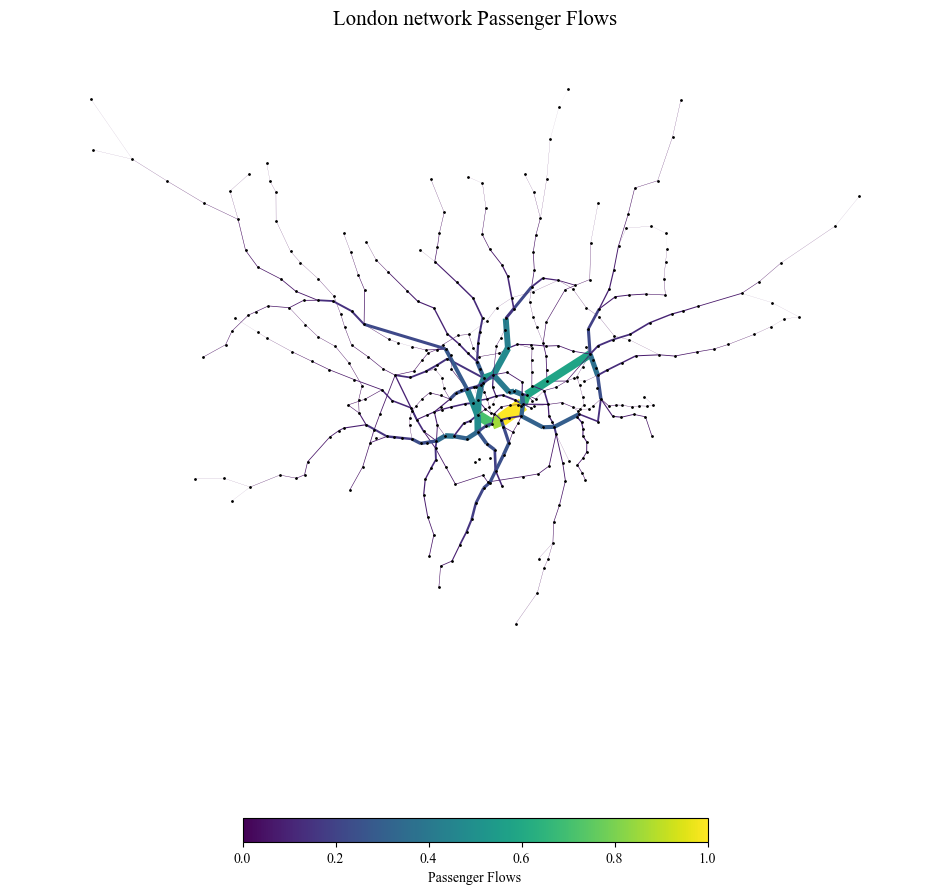

In [1486]:
#plot our calcuated flows
flows_values = flows.values()
flow_color=[(i[2]['flows']/max(flows_values)) for i in G.edges(data=True)]
flow_width=[(i[2]['flows']/max(flows_values)*10) for i in G.edges(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

#pos=nx.spring_layout(X)
edg=nx.draw_networkx_edges(G, pos,edge_color=flow_color, width=flow_width)

nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger Flows",fontsize=15)
plt.show()

In [1487]:
#get edge with highest number of flows
max(flows, key=flows.get)

('Waterloo', 'Bank and Monument')

What is going on here? Should we fix it or should we just consider it as a limitation of our model?

In [1488]:
#get edge data with lowest number of flows
min(flows, key=flows.get)

('Wandsworth Road', 'Battersea Park')

In [1489]:
#save graph
for i in G.nodes():
    G.nodes[i]['coords'] = str(G.nodes[i]['coords'])
nx.write_graphml_lxml(G, "outputs/london_updated.graph")

**Create OD pairs with distance, population and jobs**

Lastly for our spatial interaction we need to add distance data to our OD list, as well as population and jobs.
Since we don't have population and jobs data at a station level, we will use total in and out flows as proxies.

In [1490]:
#### Create Origin Destination matrix
OD = pd.pivot_table(weighted_network, 
                    values ="flows", 
                    index="station_origin", 
                    columns = "station_destination",
                    aggfunc=sum, 
                    margins=True)
OD.fillna(0, inplace=True)
OD = OD.astype(int)
OD.to_csv('outputs/OD_matrix.csv')

C:\TEMP\ipykernel_13652\4132881733.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  OD = pd.pivot_table(weighted_network,
C:\TEMP\ipykernel_13652\4132881733.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  OD = pd.pivot_table(weighted_network,
C:\TEMP\ipykernel_13652\4132881733.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  OD = pd.pivot_table(weighted_network,


In [1491]:
OD.sort_values(by='All').tail(10)

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Finsbury Park,0,0,19,156,39,0,6,1,0,34,...,16,4,113,18,0,0,0,2,0,24704
Canada Water,0,0,17,0,0,0,5,0,43,81,...,0,1,6,2,0,3,0,4,0,26995
King's Cross St. Pancras,0,0,22,842,160,0,7,2,0,135,...,38,8,71,214,0,3,0,12,0,28205
Bank and Monument,0,0,6,31,250,25,0,0,0,518,...,38,2,31,1,0,10,0,9,509,29478
Liverpool Street,0,0,12,384,150,0,3,3,0,121,...,5,1,15,53,61,12,0,1,0,31455
London Bridge,0,0,24,20,47,0,9,1,0,905,...,0,1,52,1,0,5,0,9,0,32545
Victoria,0,0,30,59,153,0,9,2,0,235,...,53,2,122,2,0,7,0,26,0,37448
Stratford,223,25,7,18,186,157,3,0,0,167,...,3,4,43,1,0,133,0,8,1106,59292
Waterloo,0,0,14,108,381,0,6,1,0,306,...,2,0,43,5,0,12,0,18,0,67337


In [1492]:
#lets get total at origin and total at destinations
origin = OD.loc[:,'All'].to_dict()
destination = OD.loc['All',:].to_dict()

In [1493]:
#lets add this data as population and jobs
weighted_network['population'] = weighted_network.station_origin.apply(lambda x: origin[x])
weighted_network['jobs'] = weighted_network.station_destination.apply(lambda x: destination[x])

In [1494]:
#get distance between stations withion the network
weighted_network['distance'] = -1
for i, row in weighted_network.iterrows():
    source = row.station_origin
    target = row.station_destination
    distance = nx.shortest_path_length(G, source, target, weight='length', method='dijkstra')
    weighted_network.loc[i, 'distance'] = distance

# or you could use all_pairs_dijkstra_path_length(G, weight='length') to get all distances at once...

C:\TEMP\ipykernel_13652\1442245745.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8131.525096864179' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weighted_network.loc[i, 'distance'] = distance


In [1495]:
weighted_network.to_csv('outputs/london_flows.csv', index=False)

There was some confusion about missing potential flows in the network for the assignment. This is how you would do the complete square matrix.

In [1496]:
# remove the ALL column and row
OD_melt = OD.iloc[:-1,:-1]
# melt OD back to a long dataframe
OD_melt = OD_melt.reset_index().melt(id_vars='station_origin', value_vars=OD.columns[:-1])
OD_melt.columns = ['station_origin', 'station_destination', 'flows']
# remove the self flows
OD_melt = OD_melt[OD_melt.station_origin != OD_melt.station_destination]
OD_melt.head()


,station_origin,station_destination,flows
1,Acton Central,Abbey Road,0
2,Acton Town,Abbey Road,0
3,Aldgate,Abbey Road,0
4,Aldgate East,Abbey Road,0
5,All Saints,Abbey Road,0


In [1497]:
OD_melt['population'] = OD_melt.station_origin.apply(lambda x: origin[x])
OD_melt['jobs'] = OD_melt.station_destination.apply(lambda x: destination[x])

In [1498]:
# get distance between stations withion the network
OD_melt['distance'] = -1
for i, row in OD_melt.iterrows():
    source = row.station_origin
    target = row.station_destination
    distance = nx.shortest_path_length(G, source, target, weight='length', method='dijkstra')
    OD_melt.loc[i, 'distance'] = distance

print(OD_melt.shape)
OD_melt.head()

C:\TEMP\ipykernel_13652\1641818707.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '23416.724397304595' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  OD_melt.loc[i, 'distance'] = distance


(157212, 6)


,station_origin,station_destination,flows,population,jobs,distance
1,Acton Central,Abbey Road,0,1224,345,23416.724397
2,Acton Town,Abbey Road,0,3701,345,23638.659673
3,Aldgate,Abbey Road,0,2883,345,7888.981451
4,Aldgate East,Abbey Road,0,3163,345,6452.560669
5,All Saints,Abbey Road,0,740,345,5250.389372


In [1499]:
OD_melt.sort_values('flows', ascending=False).head(20)

,station_origin,station_destination,flows,population,jobs,distance
6318,Waterloo,Bank and Monument,15946,67337,78523,2542.954444
22198,Waterloo,Canary Wharf,8085,67337,58743,7433.985750
84490,Stratford,Liverpool Street,6946,59292,61099,6698.461270
22048,London Bridge,Canary Wharf,6165,32545,58743,5679.209735
100002,Victoria,Oxford Circus,5181,37448,44359,2220.166284
21889,Canada Water,Canary Wharf,4030,26995,58743,2601.866276
22161,Stratford,Canary Wharf,3875,59292,58743,5482.674320
47852,Liverpool Street,Farringdon,3755,31455,25589,1602.285759
66423,Finsbury Park,Highbury & Islington,3659,24704,25369,2057.343960
84615,Canada Water,London Bridge,3202,26995,29896,3077.343459


In [1500]:
OD_melt

,station_origin,station_destination,flows,population,jobs,distance
1,Acton Central,Abbey Road,0,1224,345,23416.724397
2,Acton Town,Abbey Road,0,3701,345,23638.659673
3,Aldgate,Abbey Road,0,2883,345,7888.981451
4,Aldgate East,Abbey Road,0,3163,345,6452.560669
5,All Saints,Abbey Road,0,740,345,5250.389372
...,...,...,...,...,...,...
157603,Wood Lane,Woolwich Arsenal,0,1087,4428,26223.305923
157604,Wood Street,Woolwich Arsenal,0,1367,4428,22881.386733
157605,Woodford,Woolwich Arsenal,0,4867,4428,18856.076632
157606,Woodgrange Park,Woolwich Arsenal,0,380,4428,17486.195279


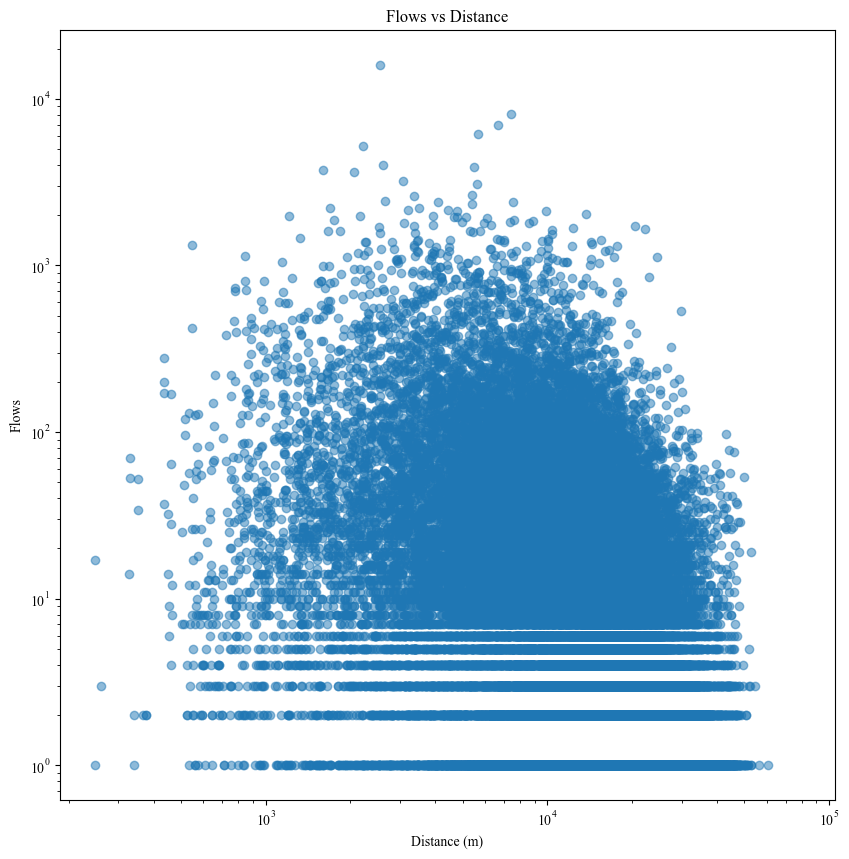

In [1501]:
# plot flows against distance, both in the log scale
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(OD_melt.distance, OD_melt.flows, alpha=0.5)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Flows')
ax.set_title('Flows vs Distance')

plt.show()

# Degree centrality (Weighted)

In [1502]:

degree_centrality = nx.degree_centrality(G)
nx.set_node_attributes(G, degree_centrality, 'degree')
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['degree'] = pd.Series(nx.get_node_attributes(G, 'degree'))

df_sorted = df.sort_values(["degree"], ascending=False)
df_sorted[0:10]

,degree
Stratford,0.0225
Bank and Monument,0.0200
Baker Street,0.0175
King's Cross St. Pancras,0.0175
Waterloo,0.0150
Earl's Court,0.0150
Canning Town,0.0150
Green Park,0.0150
Oxford Circus,0.0150
Liverpool Street,0.0150


# Clseness centrality (Weighted)

In [1510]:
for u, v, d in G.edges(data=True):
    d['flows_inverse'] =  1 / (d.get('flows', 0) + .001)
#Weighted closeness centrality: 
clos_weighted_network=nx.closeness_centrality(G, distance='flows_inverse')
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,clos_weighted_network,'closeness_w')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['closeness_w'] = pd.Series(nx.get_node_attributes(G, 'closeness_w'))

df_sorted = df.sort_values(["closeness_w"], ascending=False)
df_sorted[0:10]

,closeness_w
Green Park,0.099996
Westminster,0.099996
Waterloo,0.099996
Bank and Monument,0.099996
Oxford Circus,0.099996
Victoria,0.099996
Bond Street,0.099996
Liverpool Street,0.099996
Warren Street,0.099996
Moorgate,0.099996


# Betweenness centrality (Weighted)

In [1504]:
for u, v, d in G.edges(data=True):
    d['flows_inverse'] =  1 / (d.get('flows', 0) + .001)

bet_london_weighted_network=nx.betweenness_centrality(G,weight='flows_inverse',normalized=True)
nx.set_node_attributes(G,bet_london_weighted_network,'betweenness_w')
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['betweenness_w'] = pd.Series(nx.get_node_attributes(G, 'betweenness_w'))

wb_df_sorted = df.sort_values(["betweenness_w"], ascending=False)
wb_df_sorted[0:10]

,betweenness_w
Green Park,0.577030
Bank and Monument,0.508020
Waterloo,0.414812
Westminster,0.379574
Liverpool Street,0.339574
Stratford,0.334048
Euston,0.283810
Oxford Circus,0.277732
Bond Street,0.254549
Warren Street,0.253860


# Weighted Global efficiency and shortest path length

In [1505]:
from operator import itemgetter

In [1506]:
london_networkBRN1 = G.copy()

### Non-sequential

In [1601]:
# Function to calculate sum of reciprocal of weighted shortest paths
def calculate_sum_reciprocal_of_weighted_shortest_paths(G):
    total_weighted_path_length = 0
    total_weighted_path_count = 0
    
    for source in G.nodes():
        for target in G.nodes():
            if source != target:
                try:
                    weighted_shortest_path_lengths = nx.single_source_dijkstra(G, source=source, weight='flows_inverse')[0]
                    weighted_shortest_path_length = weighted_shortest_path_lengths.get(target)
                    if weighted_shortest_path_length is not None:
                        total_weighted_path_length += 1 / weighted_shortest_path_length
                        total_weighted_path_count += 1
                except nx.NetworkXNoPath:
                    continue
    
    print("Successfully calculated sum of reciprocal of weighted shortest paths")
    return total_weighted_path_length, total_weighted_path_count

# Function to calculate weighted global efficiency
def calculate_weighted_global_efficiency(G):
    if nx.is_connected(G):
        total_weighted_path_length, total_weighted_path_count = calculate_sum_reciprocal_of_weighted_shortest_paths(G)
        if total_weighted_path_count > 0:
            weighted_global_efficiency = total_weighted_path_length / total_weighted_path_count
        else:
            weighted_global_efficiency = 0
    else:
        return None
    return weighted_global_efficiency

# Create a copy of the original graph for node removal
G_copy = G.copy()

# Create an empty DataFrame to store results
result_df = pd.DataFrame(columns=['Accumulated Removal Points', 'Removed Node', 'Weighted Global Efficiency'])

# Calculate original weighted global efficiency
original_weighted_global_efficiency = calculate_weighted_global_efficiency(G_copy)

# Add the original efficiency to the DataFrame
result_df.loc[0] = [0, 'N/A', original_weighted_global_efficiency]

# Get the identifiers of the top 3 nodes
top_3_nodes = wb_df_sorted.head(3).index.tolist()

# Remove nodes one by one
for i, node in enumerate(top_3_nodes):
    if node in G_copy:
        print(f"Successfully removed node {node}.")
    else:
        print(f"Node {node} not found in the graph.")

    # Check if the node exists in the graph
    if node in G_copy:
        # Remove the node from the graph
        G_copy.remove_node(node)

    # Measure the weighted global efficiency after node removal
    new_weighted_global_efficiency = calculate_weighted_global_efficiency(G_copy)

    # Fill the results into the DataFrame
    result_df.loc[i + 1] = [i + 1, node, new_weighted_global_efficiency]

# Print the DataFrame
print(result_df)


Successfully calculated sum of reciprocal of weighted shortest paths
Successfully removed node Green Park.
Successfully calculated sum of reciprocal of weighted shortest paths
Successfully removed node Bank and Monument.
Successfully calculated sum of reciprocal of weighted shortest paths
Successfully removed node Waterloo.
Successfully calculated sum of reciprocal of weighted shortest paths
   Accumulated Removal Points       Removed Node  Weighted Global Efficiency
0                           0                N/A                 2643.651960
1                           1         Green Park                 2402.167826
2                           2  Bank and Monument                 2035.872006
3                           3           Waterloo                 1954.200328


In [1602]:
# Function to calculate weighted betweenness centrality
def calculate_weighted_betweenness_centrality(G):
    # Calculate weighted betweenness centrality
    weighted_betweenness = nx.betweenness_centrality(G, weight='flows_inverse')
    # Sort nodes based on their betweenness centrality in descending order
    sorted_nodes = sorted(weighted_betweenness, key=weighted_betweenness.get, reverse=True)
    return sorted_nodes

# Function to calculate weighted average shortest path length
def calculate_weighted_average_shortest_path_length(G):
    # Calculate weighted average shortest path length
    weighted_avg_shortest_path_length = nx.average_shortest_path_length(G, weight=lambda u, v, d: 1/d['flows_inverse'])
    return weighted_avg_shortest_path_length

# Create a copy of the original graph for node removal
G_copy = G.copy()

# Create an empty DataFrame to store results
result_df = pd.DataFrame(columns=['Accumulated Removal Points', 'Removed Node', 'Weighted Avg. Shortest Path Length'])

# Calculate original weighted average shortest path length
original_weighted_avg_shortest_path_length = calculate_weighted_average_shortest_path_length(G_copy)
# Add the first row to the DataFrame
result_df.loc[0] = [0, 'N/A', original_weighted_avg_shortest_path_length]

# Calculate weighted betweenness centrality
sorted_nodes = calculate_weighted_betweenness_centrality(G_copy)

# Remove the top 3 nodes based on betweenness centrality
for i in range(3):
    # Remove the node with the highest betweenness centrality
    node_to_remove = sorted_nodes[i]
    G_copy.remove_node(node_to_remove)
    # Print a message indicating successful removal of the node
    print(f"Successfully removed node {node_to_remove}.")

    # Calculate weighted average shortest path length after node removal
    new_weighted_avg_shortest_path_length = calculate_weighted_average_shortest_path_length(G_copy)

    # Add the results to the DataFrame
    result_df.loc[i + 1] = [i + 1, node_to_remove, new_weighted_avg_shortest_path_length]

# Print the DataFrame
print(result_df)

Successfully removed node Green Park.
Successfully removed node Bank and Monument.
Successfully removed node Waterloo.
   Accumulated Removal Points       Removed Node  \
0                           0                N/A   
1                           1         Green Park   
2                           2  Bank and Monument   
3                           3           Waterloo   

   Weighted Avg. Shortest Path Length  
0                       256324.832076  
1                       258452.119750  
2                       264216.003963  
3                       276358.065936  


## Sequential

In [1603]:
# Function to calculate weighted betweenness centrality
def calculate_weighted_betweenness_centrality(G):
    # Calculate the weighted betweenness centrality
    weighted_betweenness = nx.betweenness_centrality(G, weight='flows_inverse')
    # Sort nodes based on their betweenness centrality in descending order
    sorted_nodes = sorted(weighted_betweenness, key=weighted_betweenness.get, reverse=True)
    return sorted_nodes

# Create a copy of the original graph for node removal
G_copy = G.copy()

# Create an empty DataFrame to store results
result_df = pd.DataFrame(columns=['Accumulated Removal Points', 'Removed Node', 'Weighted Global Efficiency'])

# Calculate original global efficiency
original_weighted_global_efficiency = calculate_weighted_global_efficiency(G_copy)
# Add the first row to the DataFrame
result_df.loc[0] = [0, 'N/A', original_weighted_global_efficiency]

# Remove nodes iteratively
for i in range(3):  # Assuming you want to remove 3 nodes
    # Calculate weighted betweenness centrality
    sorted_nodes = calculate_weighted_betweenness_centrality(G_copy)

    # Remove the node with the highest betweenness centrality
    node_to_remove = sorted_nodes[0]
    G_copy.remove_node(node_to_remove)
    # Print a message indicating successful removal of the node
    print("Successfully removed node", node_to_remove)

    # Calculate weighted global efficiency
    weighted_global_efficiency = calculate_weighted_global_efficiency(G_copy)

    # Fill the results into the DataFrame
    result_df.loc[i + 1] = [i + 1, node_to_remove, weighted_global_efficiency]

# Print the DataFrame
print(result_df)

Successfully calculated sum of reciprocal of weighted shortest paths
Successfully removed node Green Park
Successfully calculated sum of reciprocal of weighted shortest paths
Successfully removed node Bank and Monument
Successfully calculated sum of reciprocal of weighted shortest paths
Successfully removed node King's Cross St. Pancras
Successfully calculated sum of reciprocal of weighted shortest paths
   Accumulated Removal Points              Removed Node  \
0                           0                       N/A   
1                           1                Green Park   
2                           2         Bank and Monument   
3                           3  King's Cross St. Pancras   

   Weighted Global Efficiency  
0                 2643.651960  
1                 2402.167826  
2                 2035.872006  
3                 1669.939685  


In [1604]:
# Function to calculate weighted betweenness centrality
def calculate_weighted_betweenness_centrality(G):
    # Calculate the weighted betweenness centrality
    weighted_betweenness = nx.betweenness_centrality(G, weight='flows_inverse')
    # Sort nodes based on their betweenness centrality in descending order
    sorted_nodes = sorted(weighted_betweenness, key=weighted_betweenness.get, reverse=True)
    return sorted_nodes

# Create a copy of the original graph for node removal
G_copy = G.copy()

# Create an empty DataFrame to store results
result_df = pd.DataFrame(columns=['Accumulated Removal Points', 'Removed Node', 'Weighted Avg. Shortest Path Length'])

# Calculate original weighted average shortest path length
original_weighted_avg_shortest_path_length = calculate_weighted_average_shortest_path_length(G_copy)
# Add the first row to the DataFrame
result_df.loc[0] = [0, 'N/A', original_weighted_avg_shortest_path_length]

# Remove nodes iteratively
for i in range(3):  # Assuming you want to remove 3 nodes
    # Calculate weighted betweenness centrality
    sorted_nodes = calculate_weighted_betweenness_centrality(G_copy)

    # Remove the node with the highest betweenness centrality
    node_to_remove = sorted_nodes[0]
    G_copy.remove_node(node_to_remove)
    # Print a message indicating successful removal of the node
    print("Successfully removed node", node_to_remove)

    # Calculate weighted average shortest path length
    new_weighted_avg_shortest_path_length = calculate_weighted_average_shortest_path_length(G_copy)

    # Fill the results into the DataFrame
    result_df.loc[i + 1] = [i + 1, node_to_remove, new_weighted_avg_shortest_path_length]

# Print the DataFrame
print(result_df)


Successfully removed node Green Park
Successfully removed node Bank and Monument
Successfully removed node King's Cross St. Pancras
   Accumulated Removal Points              Removed Node  \
0                           0                       N/A   
1                           1                Green Park   
2                           2         Bank and Monument   
3                           3  King's Cross St. Pancras   

   Weighted Avg. Shortest Path Length  
0                       256324.832076  
1                       258452.119750  
2                       264216.003963  
3                       272761.193901  


# Spatial interaction model

In [1514]:
#import the necessary libraries 
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats
import numpy as np
from math import sqrt
import statsmodels.formula.api as smf

In [1515]:
#set up the metric calculations
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [1557]:
spatial_interaction = pd.read_csv("C:/Users/86180/Desktop/US/cw/london_flows.csv")
spatial_interaction

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554


In [1558]:
spatial_interaction['log_job'] = np.log(spatial_interaction['jobs'] + .00001)
spatial_interaction['log_distance'] = np.log(spatial_interaction['distance'] + .00001)
spatial_interaction


,station_origin,station_destination,flows,population,jobs,distance,log_job,log_distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,9.003504
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091310,9.049012
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499787,8.236275
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,8.534348
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,7.709274
...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.114325,9.503144
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.610137,9.071245
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,5.991465,9.162905
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,6.794587,8.585832


In [1559]:
total_flow = spatial_interaction["flows"].sum()
print("Total flow between boroughs:", total_flow)

Total flow between boroughs: 1542391


In [1560]:
# Exponential distance decay
#create the formula (the "-1" indicates no intercept in the regression model).
Origin1_form = 'flows ~ station_origin + log_job + distance -1'
#run a destination constrained sim
Origin1Sim = smf.glm(formula = Origin1_form, data=spatial_interaction, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(Origin1Sim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61474
Model:                            GLM   Df Residuals:                    61073
Model Family:                 Poisson   Df Model:                          400
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.2195e+05
Date:                Tue, 23 Apr 2024   Deviance:                   1.6717e+06
Time:                        14:39:51   Pearson chi2:                 2.42e+06
No. Iterations:                    26   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [1561]:
#create the formula (the "-1" indicates no intercept in the regression model).
Origin2_form = 'flows ~ station_origin + log_job + log_distance -1'
#run a destination constrained sim
Origin2Sim = smf.glm(formula = Origin2_form, data=spatial_interaction, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(Origin2Sim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61474
Model:                            GLM   Df Residuals:                    61073
Model Family:                 Poisson   Df Model:                          400
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2520e+06
Date:                Tue, 23 Apr 2024   Deviance:                   2.3319e+06
Time:                        14:42:05   Pearson chi2:                 4.64e+06
No. Iterations:                    26   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [1566]:
#Calculate the original flow
spatial_interaction["Original_flows"] = np.round(Origin1Sim.mu)

In [1567]:
print("RSquared =")
print(CalcRSqaured(spatial_interaction["flows"], spatial_interaction["Original_flows"]))
print("RMSE =")
print(CalcRMSE(spatial_interaction["flows"], spatial_interaction["Original_flows"]))

RSquared =
0.4482759616475401
RMSE =
97.845


In [1568]:
alpha_i = Origin1Sim.params[0:399]
gamma = Origin1Sim.params[399]
beta = -Origin1Sim.params[400]

C:\TEMP\ipykernel_13652\1204429505.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma = Origin1Sim.params[399]
C:\TEMP\ipykernel_13652\1204429505.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = -Origin1Sim.params[400]


In [1569]:
alpha_i

station_origin[Abbey Road]         -2.881019
station_origin[Acton Central]      -1.147701
station_origin[Acton Town]         -1.600210
station_origin[Aldgate]            -2.912647
station_origin[Aldgate East]       -2.824605
                                      ...   
station_origin[Wood Street]        -0.927395
station_origin[Woodford]           -0.628673
station_origin[Woodgrange Park]    -0.881059
station_origin[Woodside Park]      -1.145095
station_origin[Woolwich Arsenal]    0.535723
Length: 399, dtype: float64

In [1570]:
gamma

0.7509082272799682

In [1571]:
beta

0.00015081739033056412

In [1572]:
canary_wharf_flows = spatial_interaction[spatial_interaction["station_destination"] == "Canary Wharf"]
total_canary_wharf_flows = round(canary_wharf_flows["Original_flows"].sum())
print("Total flows to Canary Wharf:", total_canary_wharf_flows)

Total flows to Canary Wharf: 48514


# Scenario A

Scenario A: assume that Canary Wharf has a 50% decrease in jobs after Brexit. Using the 
calibrated parameter b, compute the new flows for scenario A. Make sure the number of commuters is 
conserved, and explain how you ensured this. 

In [1573]:
def new_sal(row):
    if row["station_destination"] == "Canary Wharf":
        val = 29386
    else:
        val = row["jobs"]
    return val
        
spatial_interaction["newjob_Scenario"] = spatial_interaction.apply(new_sal, axis =1)
spatial_interaction.head(10)

,station_origin,station_destination,flows,population,jobs,distance,log_job,log_distance,Original_flows,newjob_Scenario
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,9.003504,78.0,78549
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091310,9.049012,2.0,442
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499787,8.236275,4.0,665
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,8.534348,99.0,29386
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,7.709274,56.0,15428
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,7.096721,8.807842,4.0,1208
6,Abbey Road,Custom House,0,599,845,3824.855630,6.739337,8.249276,5.0,845
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,7.466228,9.048280,4.0,1748
8,Abbey Road,Cyprus,7,599,850,6532.099618,6.745236,8.784484,3.0,850
9,Abbey Road,Devons Road,1,599,611,3958.324171,6.415097,8.283576,4.0,611


In [1574]:
#calculate some new Dj^gamma and d_ij^beta values
Dj3_gamma = spatial_interaction["newjob_Scenario"]**gamma
distance_beta = np.exp(spatial_interaction['distance']*(-beta))
#calcualte the first stage of the Ai values
spatial_interaction["Ai1"] = Dj3_gamma * distance_beta
#now do the sum over all js bit
A_i = pd.DataFrame(spatial_interaction.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
#and write the A_i values back into the dataframe
spatial_interaction = spatial_interaction.merge(A_i, left_on="station_origin", right_index=True, how="left")

C:\TEMP\ipykernel_13652\4268133566.py:7: FutureWarning: The provided callable <function sum at 0x0000027B5F70E200> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  A_i = pd.DataFrame(spatial_interaction.groupby(["station_origin"])["Ai1"].agg(np.sum))


In [1575]:
spatial_interaction

,station_origin,station_destination,flows,population,jobs,distance,log_job,log_distance,Original_flows,newjob_Scenario,Ai1,A_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,9.003504,78.0,78549,1390.571516,0.000100
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091310,9.049012,2.0,442,26.857372,0.000100
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499787,8.236275,4.0,665,74.540322,0.000100
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,8.534348,99.0,29386,1051.964374,0.000100
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,7.709274,56.0,15428,997.800147,0.000100
...,...,...,...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.114325,9.503144,100.0,3342,58.667702,0.000234
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.610137,9.071245,296.0,5487,172.965478,0.000234
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,5.991465,9.162905,36.0,400,21.343276,0.000234
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,6.794587,8.585832,125.0,893,73.291626,0.000234


In [1577]:

spatial_interaction["Scenario_A"] = spatial_interaction["A_i"]*spatial_interaction["population"]*Dj3_gamma*distance_beta
spatial_interaction["Scenario_A"] = round(spatial_interaction["Scenario_A"])

In [1578]:
sum_prodsimest1 = spatial_interaction["Original_flows"].sum()
sum_prodsimest4 = spatial_interaction["Scenario_A"].sum()

print("Sum of Original_flows:", sum_prodsimest1)
print("Sum of Scenario_A:", sum_prodsimest4)

Sum of Original_flows: 1541509.0
Sum of Scenario_A: 1541507.0


In [1579]:

canary_wharf_flows = spatial_interaction[spatial_interaction["station_destination"] == "Canary Wharf"]
total_canary_wharf_flows = round(canary_wharf_flows["Scenario_A"].sum())
print("Total flows to Canary Wharf:", total_canary_wharf_flows)

Total flows to Canary Wharf: 30075


In [1580]:
all_destinations = spatial_interaction["station_destination"].unique()
flows = {"Scenario_A": [], "Original_flows": []}

for destination in all_destinations:
    destination_prodsimest4 = spatial_interaction[(spatial_interaction["station_destination"] == destination)]["Scenario_A"].sum()
    destination_original_flows = spatial_interaction[(spatial_interaction["station_destination"] == destination)]["Original_flows"].sum()
    
    
    flows["Scenario_A"].append(destination_prodsimest4)
    flows["Original_flows"].append(destination_original_flows)


result = {}
for key, value in flows.items():
    result[key] = {
        "Average flow": round(np.mean(value)),
        "Median flow": round(np.median(value)),
        "Maximum flow": round(np.max(value)),
        "Minimum flow": round(np.min(value))
    }


for key, value in result.items():
    print("For {}:".format(key))
    for k, v in value.items():
        print("{}: {}".format(k, v))
    print()

For Scenario_A:
Average flow: 3863
Median flow: 998
Maximum flow: 68772
Minimum flow: 0

For Original_flows:
Average flow: 3863
Median flow: 974
Maximum flow: 67145
Minimum flow: 0



# Scenarion B

In [1581]:
beta

0.00015081739033056412

In [1582]:
SCB1 = beta*2
SCB2 = beta*4

In [1584]:
Dj_gamma_SCB = spatial_interaction["jobs"]**gamma
dist_expdecay_SCB1 = np.exp(spatial_interaction['distance']*(-SCB1))
dist_expdecay_SCB2 = np.exp(spatial_interaction['distance']*(-SCB2))

In [1585]:
spatial_interaction["alphai_SCB1"] = Dj_gamma_SCB * dist_expdecay_SCB1
spatial_interaction["alphai_SCB2"] = Dj_gamma_SCB * dist_expdecay_SCB2

In [1586]:

A_i_SCB1 = pd.DataFrame(spatial_interaction.groupby(["station_origin"])["alphai_SCB1"].agg(np.sum))
A_i_SCB1["A_i_SCB1_new"] = 1 / A_i_SCB1["alphai_SCB1"]
A_i_SCB1 = A_i_SCB1.rename(columns={"A_i_SCB1_new": "A_i_SCB1"})
print(A_i_SCB1)

                   alphai_SCB1  A_i_SCB1
station_origin                          
Abbey Road         6455.598097  0.000155
Acton Central      1388.047397  0.000720
Acton Town         4594.033257  0.000218
Aldgate           28704.551887  0.000035
Aldgate East      28457.738467  0.000035
...                        ...       ...
Wood Street         979.650377  0.001021
Woodford           1319.102243  0.000758
Woodgrange Park     556.125679  0.001798
Woodside Park      1259.349827  0.000794
Woolwich Arsenal   1174.546475  0.000851

[399 rows x 2 columns]


C:\TEMP\ipykernel_13652\265377066.py:1: FutureWarning: The provided callable <function sum at 0x0000027B5F70E200> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  A_i_SCB1 = pd.DataFrame(spatial_interaction.groupby(["station_origin"])["alphai_SCB1"].agg(np.sum))


In [1587]:

A_i_SCB2 = pd.DataFrame(spatial_interaction.groupby(["station_origin"])["alphai_SCB2"].agg(np.sum))
A_i_SCB2["A_i_SCB2_new"] = 1 / A_i_SCB2["alphai_SCB2"]
A_i_SCB2 = A_i_SCB2.rename(columns={"A_i_SCB2_new": "A_i_SCB2"})
print(A_i_SCB2)

                   alphai_SCB2  A_i_SCB2
station_origin                          
Abbey Road         3307.048365  0.000302
Acton Central       439.185443  0.002277
Acton Town          964.150079  0.001037
Aldgate           12529.010667  0.000080
Aldgate East      11877.537055  0.000084
...                        ...       ...
Wood Street         330.562393  0.003025
Woodford            175.751591  0.005690
Woodgrange Park     210.409207  0.004753
Woodside Park       184.383036  0.005423
Woolwich Arsenal    146.547987  0.006824

[399 rows x 2 columns]


C:\TEMP\ipykernel_13652\276037046.py:1: FutureWarning: The provided callable <function sum at 0x0000027B5F70E200> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  A_i_SCB2 = pd.DataFrame(spatial_interaction.groupby(["station_origin"])["alphai_SCB2"].agg(np.sum))


In [1588]:
spatial_interaction = spatial_interaction.merge(A_i_SCB1, left_on="station_origin", right_index=True, how="left")
spatial_interaction = spatial_interaction.merge(A_i_SCB2, left_on="station_origin", right_index=True, how="left")

In [1589]:
spatial_interaction["flows_SCB1"] = np.round(spatial_interaction["A_i_SCB1"]*spatial_interaction["population"]*Dj_gamma_SCB*dist_expdecay_SCB1)
spatial_interaction["flows_SCB2"] = np.round(spatial_interaction["A_i_SCB2"]*spatial_interaction["population"]*Dj_gamma_SCB*dist_expdecay_SCB2)

spatial_interaction.head()

,station_origin,station_destination,flows,population,jobs,distance,log_job,log_distance,Original_flows,newjob_Scenario,...,A_i,Scenario_A,alphai_SCB1_x,alphai_SCB2_x,alphai_SCB1_y,A_i_SCB1,alphai_SCB2_y,A_i_SCB2,flows_SCB1,flows_SCB2
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,9.003504,78.0,78549,...,0.0001,84.0,407.929640,35.105012,6455.598097,0.000155,3307.048365,0.000302,38.0,6.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091310,9.049012,2.0,442,...,0.0001,2.0,7.441452,0.571276,6455.598097,0.000155,3307.048365,0.000302,1.0,0.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499787,8.236275,4.0,665,...,0.0001,4.0,42.179608,13.505948,6455.598097,0.000155,3307.048365,0.000302,4.0,2.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,8.534348,99.0,29386,...,0.0001,63.0,822.024046,177.239167,6455.598097,0.000155,3307.048365,0.000302,76.0,32.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,7.709274,56.0,15428,...,0.0001,60.0,712.936694,363.970157,6455.598097,0.000155,3307.048365,0.000302,66.0,66.0


In [1590]:

sum_prodsimestSCB1 = spatial_interaction["flows_SCB1"].sum()
sum_prodsimestSCB2 = spatial_interaction["flows_SCB2"].sum()

print("Sum of flows_SCB1:", sum_prodsimestSCB1)
print("Sum of flows_SCB2:", sum_prodsimestSCB2)

Sum of flows_SCB1: 1540923.0
Sum of flows_SCB2: 1540934.0


In [1591]:
all_destinations = spatial_interaction["station_destination"].unique()
scenario_flows = {"Original_flows": [], "flows_SCB1": [], "flows_SCB2": []}
for destination in all_destinations:
    destination_original_flows = spatial_interaction[(spatial_interaction["station_destination"] == destination)]["Original_flows"].tolist()
    destination_flows_b1 = spatial_interaction[(spatial_interaction["station_destination"] == destination)]["flows_SCB1"].tolist()
    destination_flows_b2 = spatial_interaction[(spatial_interaction["station_destination"] == destination)]["flows_SCB2"].tolist()
    
    scenario_flows["Original_flows"].extend(destination_original_flows)
    scenario_flows["flows_SCB1"].extend(destination_flows_b1)
    scenario_flows["flows_SCB2"].extend(destination_flows_b2)

result = {}
for key, value in scenario_flows.items():
    std_deviation = np.std(value)
    result[key] = round(std_deviation)
    
for key, value in result.items():
    print("Standard deviation for {}: {}".format(key, value))

Standard deviation for Original_flows: 81
Standard deviation for flows_SCB1: 103
Standard deviation for flows_SCB2: 162


In [1592]:
Scenario_A_stats = {
    "Median": np.median(spatial_interaction["Scenario_A"]),
    "Mean": np.mean(spatial_interaction["Scenario_A"]),
    "Maximum": np.max(spatial_interaction["Scenario_A"]),
    "Minimum": np.min(spatial_interaction["Scenario_A"]),
    "25th Percentile": np.percentile(spatial_interaction["Scenario_A"], 25),
    "75th Percentile": np.percentile(spatial_interaction["Scenario_A"], 75)
}

original_flows_stats = {
    "Median": np.median(spatial_interaction["Original_flows"]),
    "Mean": np.mean(spatial_interaction["Original_flows"]),
    "Maximum": np.max(spatial_interaction["Original_flows"]),
    "Minimum": np.min(spatial_interaction["Original_flows"]),
    "25th Percentile": np.percentile(spatial_interaction["Original_flows"], 25),
    "75th Percentile": np.percentile(spatial_interaction["Original_flows"], 75)
}

print("Statistics for Scenario_A:")
for key, value in Scenario_A_stats.items():
    print("{}: {}".format(key, round(value)))

print("\nStatistics for Original_flows:")
for key, value in original_flows_stats.items():
    print("{}: {}".format(key, round(value)))

Statistics for Scenario_A:
Median: 6
Mean: 25
Maximum: 3562
Minimum: 0
25th Percentile: 1
75th Percentile: 20

Statistics for Original_flows:
Median: 6
Mean: 25
Maximum: 3533
Minimum: 0
25th Percentile: 1
75th Percentile: 20


In [1593]:

scenario_flows = {"Original_flows": spatial_interaction["Original_flows"].tolist(),
                  "flows_SCB1": spatial_interaction["flows_SCB1"].tolist(),
                  "flows_SCB2": spatial_interaction["flows_SCB2"].tolist()}

result = {}
for key, value in scenario_flows.items():
    
    median_flow = np.median(value)
    
    mean_flow = np.mean(value)
    
    max_flow = np.max(value)
    
    min_flow = np.min(value)
    
    q25 = np.percentile(value, 25)
    q75 = np.percentile(value, 75)
    
    result[key] = {
        "Median": median_flow,
        "Mean": mean_flow,
        "Maximum": max_flow,
        "Minimum": min_flow,
        "25th Percentile": q25,
        "75th Percentile": q75
    }

for key, value in result.items():
    print("Statistics for {}:".format(key))
    for stat, val in value.items():
        print("{}: {}".format(stat, round(val)))
    print()

Statistics for Original_flows:
Median: 6
Mean: 25
Maximum: 3533
Minimum: 0
25th Percentile: 1
75th Percentile: 20

Statistics for flows_SCB1:
Median: 2
Mean: 25
Maximum: 4139
Minimum: 0
25th Percentile: 0
75th Percentile: 13

Statistics for flows_SCB2:
Median: 0
Mean: 25
Maximum: 7879
Minimum: 0
25th Percentile: 0
75th Percentile: 3



# Analysis

In [1594]:
spatial_interaction

,station_origin,station_destination,flows,population,jobs,distance,log_job,log_distance,Original_flows,newjob_Scenario,...,A_i,Scenario_A,alphai_SCB1_x,alphai_SCB2_x,alphai_SCB1_y,A_i_SCB1,alphai_SCB2_y,A_i_SCB2,flows_SCB1,flows_SCB2
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,9.003504,78.0,78549,...,0.000100,84.0,407.929640,35.105012,6455.598097,0.000155,3307.048365,0.000302,38.0,6.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091310,9.049012,2.0,442,...,0.000100,2.0,7.441452,0.571276,6455.598097,0.000155,3307.048365,0.000302,1.0,0.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499787,8.236275,4.0,665,...,0.000100,4.0,42.179608,13.505948,6455.598097,0.000155,3307.048365,0.000302,4.0,2.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,8.534348,99.0,29386,...,0.000100,63.0,822.024046,177.239167,6455.598097,0.000155,3307.048365,0.000302,76.0,32.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,7.709274,56.0,15428,...,0.000100,60.0,712.936694,363.970157,6455.598097,0.000155,3307.048365,0.000302,66.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.114325,9.503144,100.0,3342,...,0.000234,108.0,7.773073,0.136452,1174.546475,0.000851,146.547987,0.006824,52.0,7.0
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.610137,9.071245,296.0,5487,...,0.000234,320.0,46.560912,3.374004,1174.546475,0.000851,146.547987,0.006824,313.0,182.0
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,5.991465,9.162905,36.0,400,...,0.000234,39.0,5.065402,0.285312,1174.546475,0.000851,146.547987,0.006824,34.0,15.0
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,6.794587,8.585832,125.0,893,...,0.000234,135.0,32.680604,6.497728,1174.546475,0.000851,146.547987,0.006824,220.0,350.0


In [1596]:
draw = spatial_interaction.drop(columns=['alphai_SCB1_x', 'alphai_SCB1_y', 'alphai_SCB2_x', 'alphai_SCB2_y','newjob_Scenario','Ai1','A_i'])
draw

,station_origin,station_destination,flows,population,jobs,distance,log_job,log_distance,Original_flows,Scenario_A,A_i_SCB1,A_i_SCB2,flows_SCB1,flows_SCB2
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,9.003504,78.0,84.0,0.000155,0.000302,38.0,6.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091310,9.049012,2.0,2.0,0.000155,0.000302,1.0,0.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499787,8.236275,4.0,4.0,0.000155,0.000302,4.0,2.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,8.534348,99.0,63.0,0.000155,0.000302,76.0,32.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,7.709274,56.0,60.0,0.000155,0.000302,66.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.114325,9.503144,100.0,108.0,0.000851,0.006824,52.0,7.0
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.610137,9.071245,296.0,320.0,0.000851,0.006824,313.0,182.0
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,5.991465,9.162905,36.0,39.0,0.000851,0.006824,34.0,15.0
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,6.794587,8.585832,125.0,135.0,0.000851,0.006824,220.0,350.0


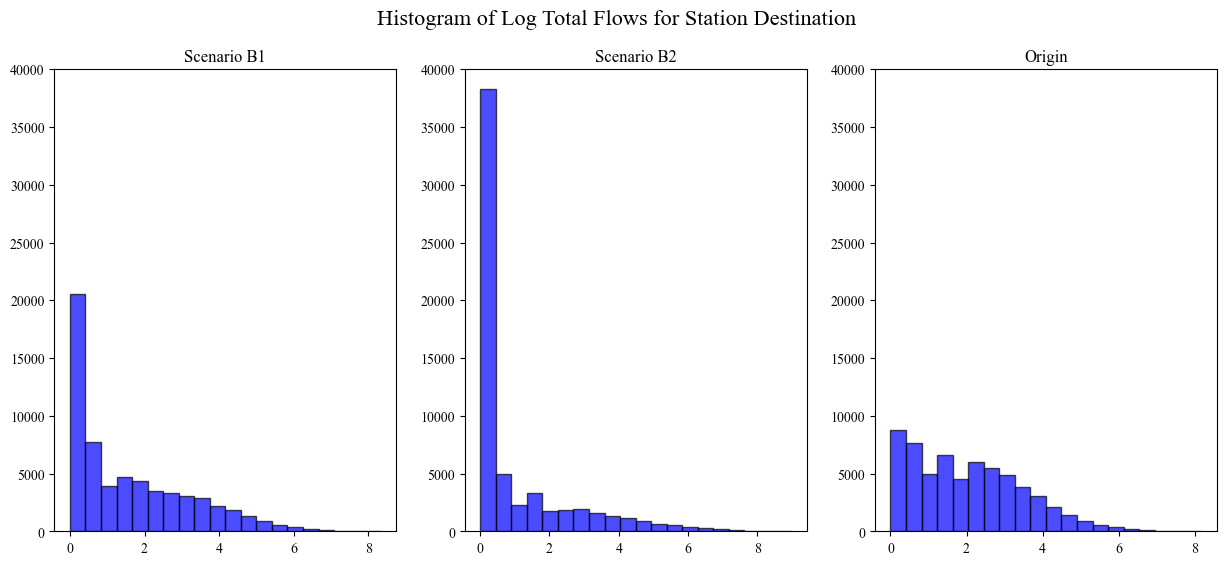

In [1598]:

plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
draw['log_flows'] = np.log(draw['flows_SCB1'] + 1)
plt.hist(draw['log_flows'], bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title('Scenario B1')
plt.ylim(0, 40000)
plt.subplot(1, 3, 2)
draw['log_flows'] = np.log(draw['flows_SCB2'] + 1)  # 加上1是为了避免出现log(0)
plt.hist(draw['log_flows'], bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title('Scenario B2')
plt.ylim(0, 40000)
plt.subplot(1, 3, 3)
draw['log_flows'] = np.log(draw['Original_flows'] + 1)  # 加上1是为了避免出现log(0)
plt.hist(draw['log_flows'], bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title('Origin')
plt.ylim(0, 40000)
plt.suptitle('Histogram of Log Total Flows for Station Destination', fontsize=16)
plt.show()

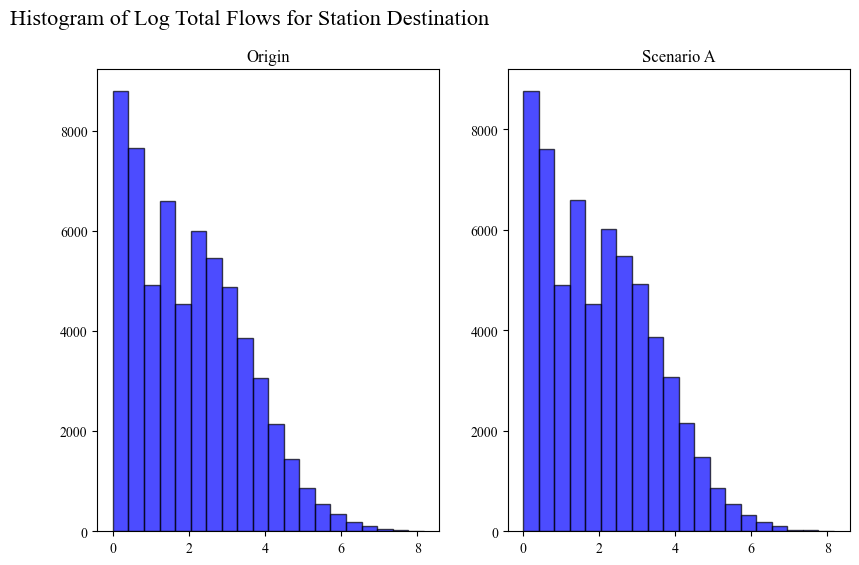

In [1600]:

plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 2)
draw['log_flows'] = np.log(draw['Original_flows'] + 1)
plt.hist(draw['log_flows'], bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title('Origin')
plt.subplot(1, 3, 3)
draw['log_flows'] = np.log(draw['Scenario_A'] + 1)
plt.hist(draw['log_flows'], bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title('Scenario A')
plt.suptitle('Histogram of Log Total Flows for Station Destination', fontsize=16)
plt.show()

# exercise
#### Part A 
Let's calculate the flows between 2 stations in the network by combing origin-destinction data with topogical data.

+ Get the flows between 2 stations that are separated by a single station (a --> b --> c) on the network
+ Find a way to separate out the flows between a and c from those between a and b and b and c

#### Part B
What are the limitations of this undirected network? Let's go back and think about a directed network.

In [ ]:
# recreate our network but with directional Graph by specifying create_using parameter!
G_di = nx.from_pandas_edgelist(edge_gdf, source = 'start_id', target='end_id', edge_attr=['length', 'line_name'], create_using=nx.DiGraph)

# we need to add an extra step to iterate through the edges from the opposite direction 
for i, edge in edge_gdf.iterrows():
    if not G_di.has_edge(edge['end_id'], edge['start_id']):
        G_di.add_edge(edge['end_id'], edge['start_id'], length=edge['length'], line_name=edge['line_name'])

# adding the position of the nodes
pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G_di.nodes()}
nx.set_node_attributes(G_di, pos, 'coords')

What are some questions that you can ask with this directed network that you can't with the undirected network?

+ Let's call a station's "directionality" the difference between the number of people going through a station in one direction and the other.
+ Which stations have the highest directionality?
+ What about the lowest? 